 ## Classification and Generalized Linear Regression with Probabilistic Models

 ### Problem 1 [3 marks] 

During our lab in Lecture 2 (on Linear Models and Regularization), we ran an experiment to compare linear regression with ordinary least squares, ridge regression, and the lasso on predicting diabetes disease progression. It was noted at the end of the lab that there did not appear to be strong evidence that any model was significantly outperforming the other. This was exemplified when we saw the following plot:

<div align="center">
  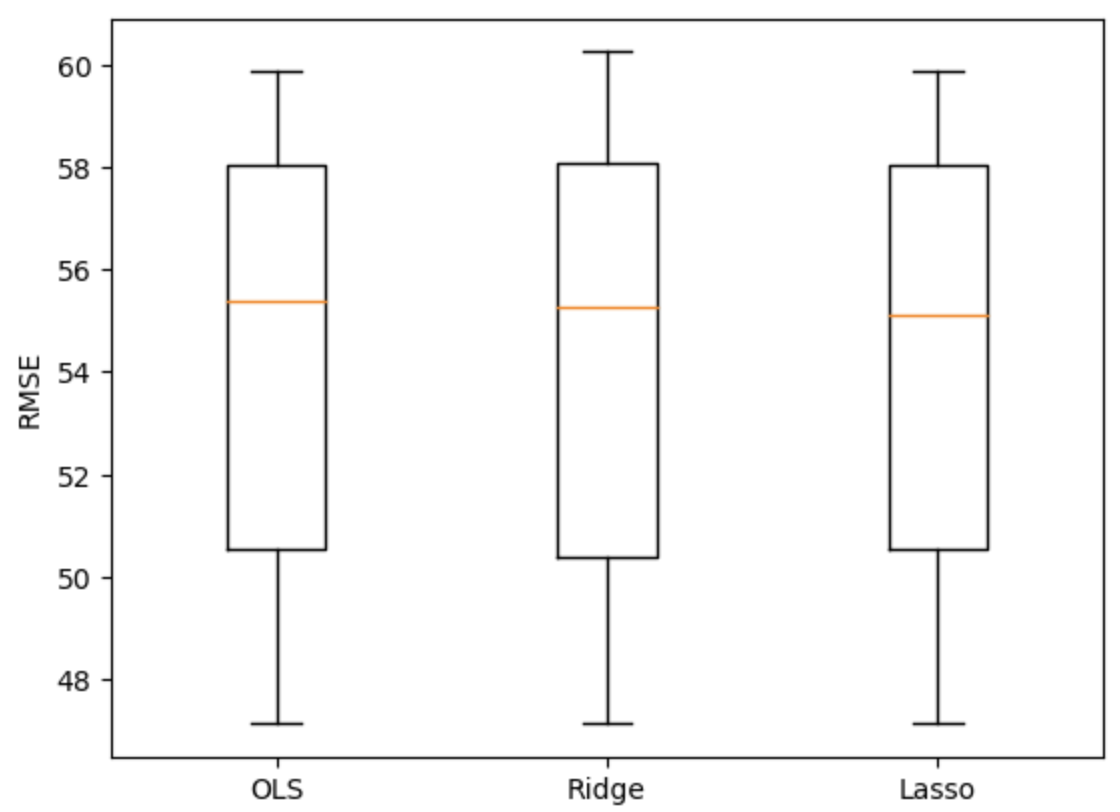
</div>

However, if you ran this experiment again, you may find that the results change. How do we interpret this? This happens due to noise and possibly due to the limitations of the models we are using. This result further highlights the uncertainty these models have when making predictions on this dataset. How can we try to explore this further? 

One idea is to increase the number of cross-validation splits (in attempts to decrease our uncertainty in our estimates). Rerun the experiment with an increased number of cross validation splits and analyze your results. Consider using hypothesis tests, such as the paired t-test with something like:

`from scipy.stats import ttest_rel`

`p_ = ttest_rel(errors_lr, errors_ridge).pvalue `

`print("p-value of paired t-test between OLS and Ridge:", p_)`

to compare the performance of different models (as we did during the lab). Make a conclusion about this dataset and your ability to predict the outcome with the models at hand.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV

df = pd.read_csv('./diabetes.csv')
#df.columns

In [2]:
np.random.seed(5227)

In [3]:
Y = df['Y']
n = df.shape[0]
sex = np.zeros(n)
for i in range(n):
    if df['SEX'].iloc[i] == 1: 
        sex[i] = 1
    else:
        sex[i] = 0
columns_i_want = ['AGE', 'BMI', 'BP', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6']
X = df[columns_i_want].copy()
X.loc[:, 'SEX=1'] = sex

In [4]:
#X.head()

In [5]:
#Y.head()

I standardize the predictors before using ridge regression and Lasso. Then, I increased number of cross-validation splits to 70 for more robust analysis and rerun the experiment with an increased number of cross validation splits and analyze your results using hypothesis tests paired t-test to select the penalty parameter $\lambda$, and to compare predictive performance of the models. 

In [6]:
n_cv = 70

errors_lr = []
errors_ridge = []
errors_lasso = []

indices = list(range(len(df)))
n_train = int(len(df) * .85)

for k in range(n_cv):
    
    np.random.shuffle(indices)
    train_inds = indices[:n_train]
    test_inds = indices[n_train:]

    Y_train = Y.iloc[train_inds]
    X_train = X.iloc[train_inds, :].copy()
    
    Y_test = Y.iloc[test_inds]
    X_test = X.iloc[test_inds, :].copy()
    
    for feature_name in ['AGE', 'BMI', 'BP', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6']:
        mean_ = X_train[feature_name].mean()
        std_ = X_train[feature_name].std()
        X_train[feature_name] = (X_train[feature_name] - mean_) / std_
        X_test[feature_name] = (X_test[feature_name] - mean_) / std_
    
    lr = LinearRegression(fit_intercept=True).fit(X_train, Y_train) 
    Y_pred = lr.predict(X_test)
    rmse = np.sqrt(np.mean((Y_test - Y_pred) ** 2))
    errors_lr.append(rmse)

    ridge = RidgeCV(alphas=np.linspace(0.001, 100.0, 100), fit_intercept=True, cv=10).fit(X_train, Y_train)
    Y_pred = ridge.predict(X_test) 
    rmse = np.sqrt(np.mean((Y_test - Y_pred) ** 2))
    errors_ridge.append(rmse)

    lasso = LassoCV(alphas=np.linspace(0.001, 100.0, 100), fit_intercept=True, cv=10).fit(X_train, Y_train)
    Y_pred = lasso.predict(X_test)
    rmse = np.sqrt(np.mean((Y_test - Y_pred) ** 2))
    errors_lasso.append(rmse)

In [7]:
print(f"the average squared prediction error of LinearRegression: {np.mean(errors_lr):.4f}")
print(f"the average squared prediction error of RidgeCV: {np.mean(errors_ridge):.4f}")
print(f"the average squared prediction error of LassoCV: {np.mean(errors_lasso):.4f}")

the average squared prediction error of LinearRegression: 55.6181
the average squared prediction error of RidgeCV: 55.7450
the average squared prediction error of LassoCV: 55.7366


When I run this, Lasso wins. But note that it is possible that you rerun the code and a different model wins. consequently, after implementing three models, I want to test whether one model is consistently outperforming another, or whether this result is just noise. 

Explore the weights for each of the models by visualizing them. When I run this, the weights for three models look a little bit different. Lasso does set some of the coefficients to zero. OLS have positive S3 coefficients, but Ridge coefficients is negative in these two. 

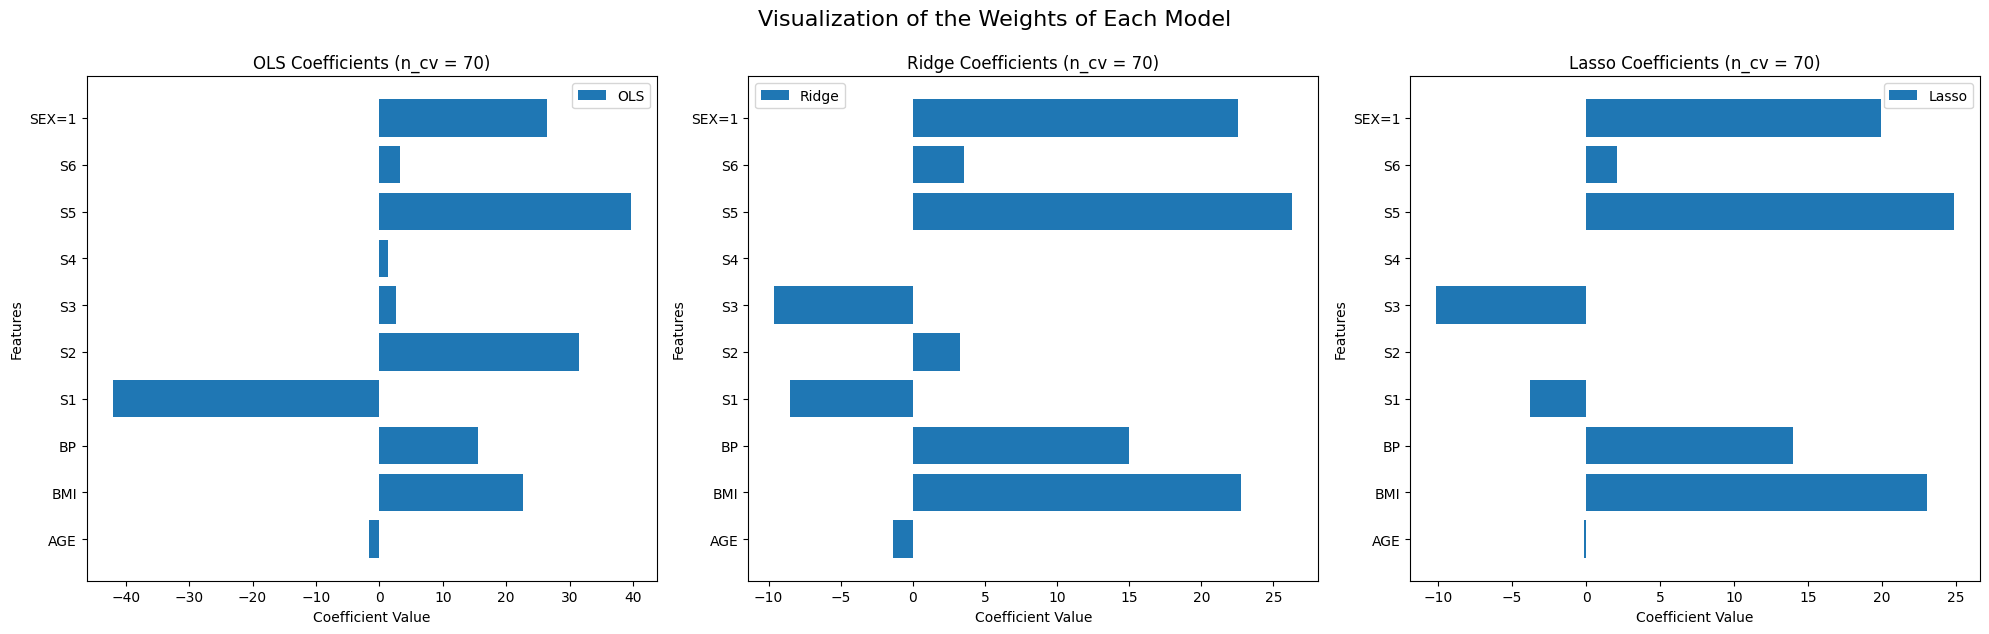

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

# Ordinary Least Squares (OLS) coefficients
coefs_ = pd.Series(lr.coef_, index=X.columns)
axes[0].barh(coefs_.index, coefs_.values)
axes[0].set_title(f'OLS Coefficients (n_cv = {n_cv})')
axes[0].set_xlabel('Coefficient Value')
axes[0].set_ylabel('Features')
axes[0].legend(['OLS'], loc='best')

# Ridge coefficients
coefs_ = pd.Series(ridge.coef_, index=X.columns)
axes[1].barh(coefs_.index, coefs_.values)
axes[1].set_title(f'Ridge Coefficients (n_cv = {n_cv})')
axes[1].set_xlabel('Coefficient Value')
axes[1].set_ylabel('Features')
axes[1].legend(['Ridge'], loc='best')

# Lasso coefficients
coefs_ = pd.Series(lasso.coef_, index=X.columns)
axes[2].barh(coefs_.index, coefs_.values)
axes[2].set_title(f'Lasso Coefficients (n_cv = {n_cv})')
axes[2].set_xlabel('Coefficient Value')
axes[2].set_ylabel('Features')
axes[2].legend(['Lasso'], loc='best')

plt.tight_layout()
plt.suptitle("Visualization of the Weights of Each Model", fontsize=16, y=1.05)
plt.show()

Take a look at some penalty parameters that are selected by the `RidgeCV` and `LassoCV` methods. The following parameters are those found with the last test set:

In [9]:
print(f"Ridge penalty found by CV: {ridge.alpha_:.4f}")
print(f"Lasso penalty found by CV: {lasso.alpha_:.4f}")

Ridge penalty found by CV: 11.1120
Lasso penalty found by CV: 1.0111


Consider the noise over the test sets. Plot boxplots to compare the populations of test errors across the methods. 

Run a statistical (hypothesis) test that two of these sets of scores significantly differ using the `scipy.stats.ttest_rel()` method to run a paired t-test, which tests whether the means of two paired samples differs significantly.

OLS average test error: 55.6181
Ridge average test error: 55.7450
Lasso average test error: 55.7366


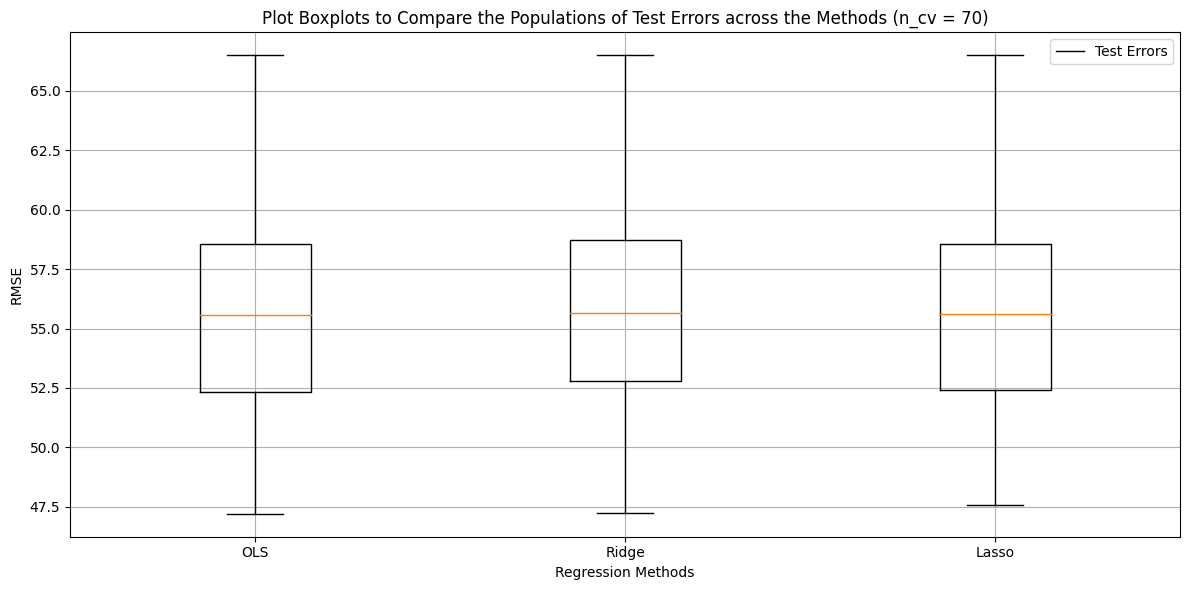

In [10]:
print(f"OLS average test error: {np.average(errors_lr):.4f}")
print(f"Ridge average test error: {np.mean(errors_ridge):.4f}")
print(f"Lasso average test error: {np.mean(errors_lasso):.4f}")

plt.figure(figsize=(12, 6))
plt.title("Plot Boxplots to Compare the Populations of Test Errors across the Methods (n_cv = 70)")
plt.boxplot([errors_lr, errors_ridge, errors_lasso], labels=['OLS', 'Ridge', 'Lasso'])
plt.xticks([1, 2, 3], ['OLS', 'Ridge', 'Lasso'])
plt.ylabel('RMSE')
plt.xlabel('Regression Methods')
plt.legend(['Test Errors'], loc='upper right')
plt.tight_layout()
plt.grid(True)
plt.show()

In [12]:
from scipy.stats import ttest_rel

p_ = ttest_rel(errors_lr, errors_ridge).pvalue
print(f"p-value of paired t-test between OLS and Ridge: {p_:.4f}")

p_ = ttest_rel(errors_lr, errors_lasso).pvalue
print(f"p-value of paired t-test between OLS and Lasso: {p_:.4f}")

p_ = ttest_rel(errors_lasso, errors_ridge).pvalue
print(f"p-value of paired t-test between Lasso and Ridge: {p_:.4f}")

p-value of paired t-test between OLS and Ridge: 0.0273
p-value of paired t-test between OLS and Lasso: 0.0384
p-value of paired t-test between Lasso and Ridge: 0.8324


The p-values of look significant for p-value of paired t-test between OLS and Ridge as well as p-value of paired t-test between OLS and Lasso. So I would say there is good evidence that one is consistently outperforming the other. Considering the mean errors, the OLS should be slightly outperform others. 

 ### Problem 2 [6 marks]
During Lecture 3, it was noted that log-likelihood scores can themselves be used as an evaluation metric for a probabilistic model. In our lab during Lecture 3 (on Logistic Regression and Generalized Linear Models), repeat both the classification experiment (predicting ’DEFAULT’) and the count regression experiment (predicting ’CREDIT’) but this time use the log-likelihood as a performance metric. Visualize a comparison of the scores over the test sets between the models in each case. The following functions and hints may be helpful:

• `numpy.log` computes the natural logarithm

• `scipy.special.gammaln` computes $log(Γ(x))$

• Recall that $Γ(x + 1) = x!$ for any integer $x ≥ 0$ and that $0! := 1$.

Finally, use a hypothesis test (such as a paired t-test) to determine if there is good evidence (or lack thereof) that the performance between any two models differ significantly based on this metric. Compare the findings using this metric to other metrics we considered in lab.

In [13]:
df = pd.read_csv('credit_score.csv')
#df.columns

In [14]:
Y_default = df['DEFAULT']
Y_credit = df['CREDIT_SCORE']
predictors = []
for key in df.columns:
    if (key != 'DEFAULT') and (key != 'CREDIT_SCORE'):
        predictors.append(key)
X = df[predictors]
#X.head()

In [15]:
X_w_dummies = pd.get_dummies(data=X, columns=['CAT_GAMBLING'], dtype=int, drop_first=True)

In [16]:
X_w_dummies = X_w_dummies.drop("CUST_ID", axis=1)

In [17]:
columns_to_normalize = [
       'INCOME', 'SAVINGS', 'DEBT', 'R_SAVINGS_INCOME', 'R_DEBT_INCOME',
       'R_DEBT_SAVINGS', 'T_CLOTHING_12', 'T_CLOTHING_6', 'R_CLOTHING',
       'R_CLOTHING_INCOME', 'R_CLOTHING_SAVINGS', 'R_CLOTHING_DEBT',
       'T_EDUCATION_12', 'T_EDUCATION_6', 'R_EDUCATION', 'R_EDUCATION_INCOME',
       'R_EDUCATION_SAVINGS', 'R_EDUCATION_DEBT', 'T_ENTERTAINMENT_12',
       'T_ENTERTAINMENT_6', 'R_ENTERTAINMENT', 'R_ENTERTAINMENT_INCOME',
       'R_ENTERTAINMENT_SAVINGS', 'R_ENTERTAINMENT_DEBT', 'T_FINES_12',
       'T_FINES_6', 'R_FINES', 'R_FINES_INCOME', 'R_FINES_SAVINGS',
       'R_FINES_DEBT', 'T_GAMBLING_12', 'T_GAMBLING_6', 'R_GAMBLING',
       'R_GAMBLING_INCOME', 'R_GAMBLING_SAVINGS', 'R_GAMBLING_DEBT',
       'T_GROCERIES_12', 'T_GROCERIES_6', 'R_GROCERIES', 'R_GROCERIES_INCOME',
       'R_GROCERIES_SAVINGS', 'R_GROCERIES_DEBT', 'T_HEALTH_12', 'T_HEALTH_6',
       'R_HEALTH', 'R_HEALTH_INCOME', 'R_HEALTH_SAVINGS', 'R_HEALTH_DEBT',
       'T_HOUSING_12', 'T_HOUSING_6', 'R_HOUSING', 'R_HOUSING_INCOME',
       'R_HOUSING_SAVINGS', 'R_HOUSING_DEBT', 'T_TAX_12', 'T_TAX_6', 'R_TAX',
       'R_TAX_INCOME', 'R_TAX_SAVINGS', 'R_TAX_DEBT', 'T_TRAVEL_12',
       'T_TRAVEL_6', 'R_TRAVEL', 'R_TRAVEL_INCOME', 'R_TRAVEL_SAVINGS',
       'R_TRAVEL_DEBT', 'T_UTILITIES_12', 'T_UTILITIES_6', 'R_UTILITIES',
       'R_UTILITIES_INCOME', 'R_UTILITIES_SAVINGS', 'R_UTILITIES_DEBT',
       'T_EXPENDITURE_12', 'T_EXPENDITURE_6', 'R_EXPENDITURE',
       'R_EXPENDITURE_INCOME', 'R_EXPENDITURE_SAVINGS', 'R_EXPENDITURE_DEBT',
]
a = {}
a['a'] = 1
a['b'] = 2
a['c'] = 'hello'

Define the log-likelihood functions for both classification and count outcomes.

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from scipy.special import gammaln

import matplotlib.pyplot as plt
import time

In [19]:
def log_likelihood_classification(y_true, p_pred, epsilon=1e-15):
    p_pred = np.clip(p_pred, epsilon, 1 - epsilon)
    return np.sum(y_true * np.log(p_pred) + (1 - y_true) * np.log(1 - p_pred))

def log_likelihood_count(y_true, lambda_pred, epsilon=1e-15):
    lambda_pred = np.clip(lambda_pred, epsilon, np.inf)
    return np.sum(y_true * np.log(lambda_pred) - lambda_pred - gammaln(y_true + 1))

In [20]:
scores_ll = {'logreg': [], 'logreg_l1': [], 'logreg_l2': []}

In [21]:
n_splits = 20  # we will do 20 cross validation splits

indices = list(range(X_w_dummies.shape[0]))
n_train = int(len(indices) * .85)  # 85% train, 15% split

scores = {} 
for model_name in ['logreg', 'logreg_l1', 'logreg_l2']:
    scores[model_name] = []

Repeat both the classification experiment (predicting ’DEFAULT’) and the count regression experiment (predicting ’CREDIT’) using the log-likelihood as a performance metric. 

In [22]:
for i_ in range(n_splits):
    
    t_start = time.time()
    np.random.seed(5227)
    np.random.shuffle(indices)
    train_inds = indices[:n_train]
    test_inds = indices[n_train:]
    
    X_train = X_w_dummies.iloc[train_inds, :].copy()
    X_test = X_w_dummies.iloc[test_inds, :].copy()
    
    Y_train = Y_default.iloc[train_inds]
    Y_test = Y_default.iloc[test_inds]
    
    # standardize the predictors
    for key in columns_to_normalize:
        x_mean = X_train[key].mean()
        x_std = X_train[key].std()
        X_train.loc[:, key] = (X_train[key] - x_mean) / x_std
        X_test.loc[:, key] = (X_test[key] - x_mean) / x_std
    
    clf = LogisticRegression(penalty=None, max_iter=10000)
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict_proba(X_test)
    # print(clf.classes_)
    Y_pred_P1 = Y_pred[:, 1]  # P(Y=1)
    ll_score = log_likelihood_classification(Y_test, Y_pred_P1)
    scores_ll['logreg'].append(ll_score)
    print("Finished logreg split:", i_)
    
    clf = LogisticRegressionCV(penalty='l1', solver='saga', max_iter=10000)
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict_proba(X_test)
    Y_pred_P1 = Y_pred[:, 1]
    ll_score = log_likelihood_classification(Y_test, Y_pred_P1)
    scores_ll['logreg_l1'].append(ll_score)
    print("Finished logreg l1 split:", i_)
    
    clf = LogisticRegressionCV(penalty='l2', max_iter=10000)  # uses 5-fold cross validation by default
    clf.fit(X_train, Y_train)  
    Y_pred = clf.predict_proba(X_test) 
    Y_pred_P1 = Y_pred[:, 1] 
    ll_score = log_likelihood_classification(Y_test, Y_pred_P1)
    scores_ll['logreg_l2'].append(ll_score)
    print("Finished logreg l2 split:", i_)
    
    t_elapsed = time.time() - t_start
    print("This split took: %.2f secs" % t_elapsed)

Finished logreg split: 0
Finished logreg l1 split: 0
Finished logreg l2 split: 0
This split took: 23.08 secs
Finished logreg split: 1
Finished logreg l1 split: 1
Finished logreg l2 split: 1
This split took: 15.06 secs
Finished logreg split: 2
Finished logreg l1 split: 2
Finished logreg l2 split: 2
This split took: 20.59 secs
Finished logreg split: 3
Finished logreg l1 split: 3
Finished logreg l2 split: 3
This split took: 20.15 secs
Finished logreg split: 4
Finished logreg l1 split: 4
Finished logreg l2 split: 4
This split took: 22.80 secs
Finished logreg split: 5
Finished logreg l1 split: 5
Finished logreg l2 split: 5
This split took: 18.70 secs
Finished logreg split: 6
Finished logreg l1 split: 6
Finished logreg l2 split: 6
This split took: 19.15 secs
Finished logreg split: 7
Finished logreg l1 split: 7
Finished logreg l2 split: 7
This split took: 19.49 secs
Finished logreg split: 8
Finished logreg l1 split: 8
Finished logreg l2 split: 8
This split took: 19.74 secs
Finished logreg spl

Visualize a comparison of the scores over the test sets between the models in each case.

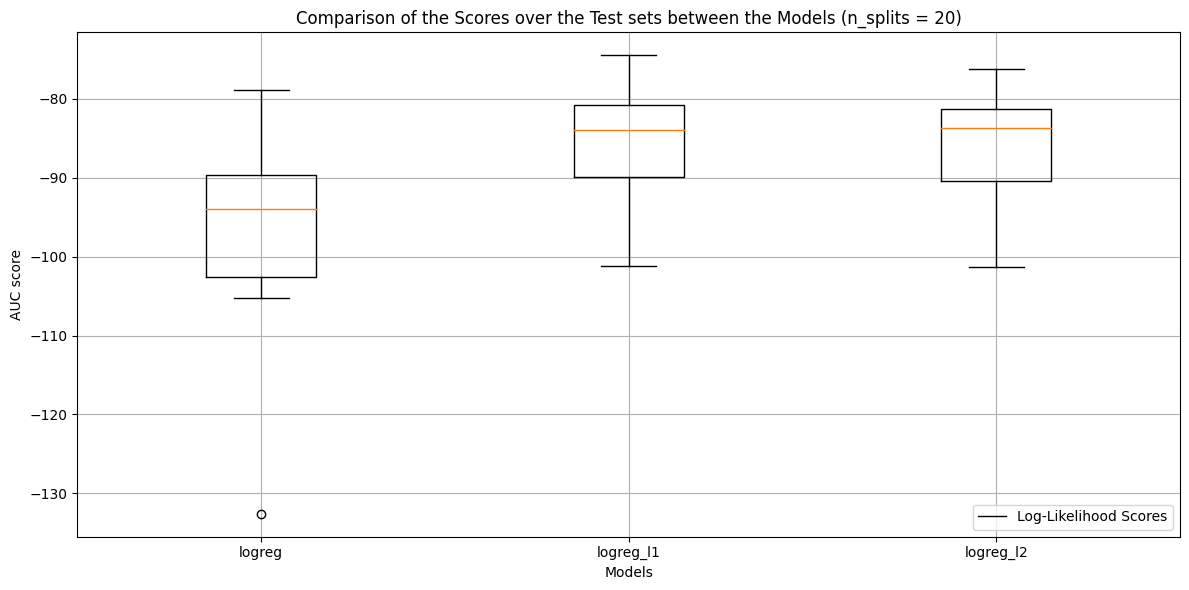

In [23]:
plt.figure(figsize=(12, 6))
plt.title("Comparison of the Scores over the Test sets between the Models (n_splits = 20)")
plt.boxplot([scores_ll['logreg'], scores_ll['logreg_l1'], scores_ll['logreg_l2']], 
            labels=['logreg', 'logreg_l1', 'logreg_l2'])
plt.ylabel('AUC score')
plt.xlabel('Models')
plt.legend(['Log-Likelihood Scores'], loc='lower right')
plt.tight_layout()
plt.grid(True)
plt.show()

Use the `wilcoxon` and `ttest_rel` function from `scipy.stats` to perform Wilcoxon signed-rank test and paired t-tests between the log-likelihood scores of different models.

In [25]:
from scipy.stats import wilcoxon, ttest_rel

print(f"p-value of Wilcoxon signed-rank test between regularization (logreg) and regularization (logreg_l1): {wilcoxon(scores_ll['logreg'], scores_ll['logreg_l1']).pvalue:.6f}")
print(f"p-value of Wilcoxon signed-rank test between regularization (logreg_l1) and regularization (logreg_l2): {wilcoxon(scores_ll['logreg_l2'], scores_ll['logreg_l1']).pvalue:.6f}")
print(f"p-value of Wilcoxon signed-rank test between regularization (logreg) and regularization (logreg_l2): {wilcoxon(scores_ll['logreg'], scores_ll['logreg_l2']).pvalue:.6f}")
print(f"p-value of Paired T-test between regularization (logreg) and regularization (logreg_l1): {ttest_rel(scores_ll['logreg'], scores_ll['logreg_l1']).pvalue:.6f}")
print(f"p-value of Paired T-test between regularization (logreg_l1) and regularization (logreg_l2): {ttest_rel(scores_ll['logreg_l2'], scores_ll['logreg_l1']).pvalue:.6f}")
print(f"p-value of Paired T-test between regularization (logreg) and regularization (logreg_l2): {ttest_rel(scores_ll['logreg'], scores_ll['logreg_l2']).pvalue:.6f}")

p-value of Wilcoxon signed-rank test between regularization (logreg) and regularization (logreg_l1): 0.000004
p-value of Wilcoxon signed-rank test between regularization (logreg_l1) and regularization (logreg_l2): 0.595819
p-value of Wilcoxon signed-rank test between regularization (logreg) and regularization (logreg_l2): 0.000002
p-value of Paired T-test between regularization (logreg) and regularization (logreg_l1): 0.000056
p-value of Paired T-test between regularization (logreg_l1) and regularization (logreg_l2): 0.797080
p-value of Paired T-test between regularization (logreg) and regularization (logreg_l2): 0.000069


The p-values of Wilcoxon signed-rank test and the paired t-test comparing the log-likelihood scores of these models suggest significant differences in performance between models without regularization (logreg) and those with regularization (logreg_l1 and logreg_l2).

Comparisons between L1 and L2 regularization models (logreg_l1 vs. logreg_l2) showed no significant difference in one of the tests, suggesting that the choice between L1 and L2 regularization may not significantly affect the model performance in this specific context, or the differences are not captured by the log-likelihood metric used.

The significant p-values indicate that the regularization technique employed can have a statistically significant effect on the logistic regression model's predictive performance, as measured by log-likelihood. This highlights the importance of selecting the appropriate regularization method based on the data and the specific problem being addressed.

In [26]:
from sklearn.linear_model import RidgeCV, LassoCV, PoissonRegressor
from sklearn.model_selection import GridSearchCV
import time

n_splits = 10  # number of cross validation splits

indices = list(range(X_w_dummies.shape[0]))
n_train = int(len(indices) * .85)  # 85% train, 15% split

scores = {} 
for model_name in ['ridge', 'lasso', 'poisson', 'poisson_cv']:
    scores[model_name] = []

for i_ in range(n_splits):
    
    t_start = time.time()
    np.random.seed(5227)
    np.random.shuffle(indices)
    train_inds = indices[:n_train]
    test_inds = indices[n_train:]
    
    X_train = X_w_dummies.iloc[train_inds, :].copy()
    X_test = X_w_dummies.iloc[test_inds, :].copy()
    
    Y_train = Y_credit.iloc[train_inds]
    Y_test = Y_credit.iloc[test_inds]
    
    # standardize the predictors
    for key in columns_to_normalize:
        x_mean = X_train[key].mean()
        x_std = X_train[key].std()
        X_train.loc[:, key] = (X_train[key] - x_mean) / x_std
        X_test.loc[:, key] = (X_test[key] - x_mean) / x_std
    
    model = RidgeCV()  # uses 5-fold cross validation by default
    model.fit(X_train, Y_train)  
    Y_pred = model.predict(X_test) 
    loglikelihood = log_likelihood_count(Y_test, Y_pred)
    scores['ridge'].append(loglikelihood)
    print("Finished ridge split:", i_)
    
    model = LassoCV(max_iter=2000)  # uses 5-fold cross validation by default
    model.fit(X_train, Y_train)  
    Y_pred = model.predict(X_test) 
    loglikelihood = log_likelihood_count(Y_test, Y_pred)
    scores['lasso'].append(loglikelihood)
    print("Finished lasso split:", i_)
    
    # Poisson Regressor uses L2 regularization with a penalty parameter alpha=1 by default!
    model = PoissonRegressor(max_iter=10000)
    model.fit(X_train, Y_train)  
    Y_pred = model.predict(X_test)
    loglikelihood = log_likelihood_count(Y_test, Y_pred)
    scores['poisson'].append(loglikelihood)
    print("Finished poisson split:", i_)
    
    regressor = PoissonRegressor(max_iter=10000)
    model = GridSearchCV(estimator=regressor, param_grid={'alpha': np.linspace(0.1, 10, 10)})  # uses 5-fold cross validation by default
    model.fit(X_train, Y_train)  
    Y_pred = model.predict(X_test)
    loglikelihood = log_likelihood_count(Y_test, Y_pred)
    scores['poisson_cv'].append(loglikelihood)
    print("Finished poisson CV split:", i_)
    
    t_elapsed = time.time() - t_start
    print("This split took: %.2f secs" % t_elapsed)

Finished ridge split: 0
Finished lasso split: 0
Finished poisson split: 0
Finished poisson CV split: 0
This split took: 11.86 secs
Finished ridge split: 1
Finished lasso split: 1
Finished poisson split: 1
Finished poisson CV split: 1
This split took: 10.62 secs
Finished ridge split: 2
Finished lasso split: 2
Finished poisson split: 2
Finished poisson CV split: 2
This split took: 7.57 secs
Finished ridge split: 3
Finished lasso split: 3
Finished poisson split: 3
Finished poisson CV split: 3
This split took: 12.56 secs
Finished ridge split: 4
Finished lasso split: 4
Finished poisson split: 4
Finished poisson CV split: 4
This split took: 8.99 secs
Finished ridge split: 5
Finished lasso split: 5
Finished poisson split: 5
Finished poisson CV split: 5
This split took: 7.64 secs
Finished ridge split: 6
Finished lasso split: 6
Finished poisson split: 6
Finished poisson CV split: 6
This split took: 8.57 secs
Finished ridge split: 7
Finished lasso split: 7
Finished poisson split: 7
Finished pois

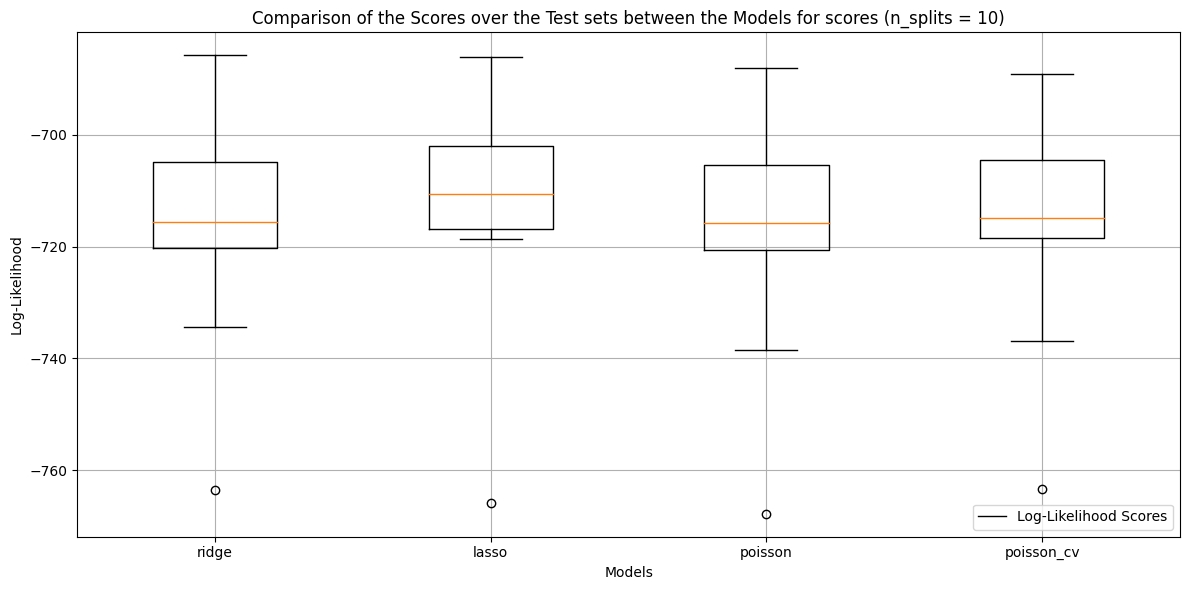

In [27]:
plt.figure(figsize=(12, 6))
plt.title("Comparison of the Scores over the Test sets between the Models for scores (n_splits = 10)")
plt.boxplot([scores['ridge'], scores['lasso'], scores['poisson'], scores['poisson_cv']], 
            labels=['ridge', 'lasso', 'poisson', 'poisson_cv'])
plt.ylabel('Log-Likelihood')
plt.xlabel('Models')
plt.legend(['Log-Likelihood Scores'], loc='lower right')
plt.tight_layout()
plt.grid(True)
plt.show()

In [29]:
from scipy.stats import wilcoxon, ttest_rel

print(f"p-value of Wilcoxon signed-rank test between ridge and lasso: {wilcoxon(scores['ridge'], scores['lasso']).pvalue:.6f}")
print(f"p-value of Wilcoxon signed-rank test between ridge and poisson: {wilcoxon(scores['ridge'], scores['poisson']).pvalue:.6f}")
print(f"p-value of Wilcoxon signed-rank test between ridge and poisson_cv: {wilcoxon(scores['ridge'], scores['poisson_cv']).pvalue:.6f}")
print(f"p-value of Wilcoxon signed-rank test between lasso and poisson: {wilcoxon(scores['lasso'], scores['poisson']).pvalue:.6f}")
print(f"p-value of Wilcoxon signed-rank test between lasso and poisson_cv: {wilcoxon(scores['lasso'], scores['poisson_cv']).pvalue:.6f}")
print(f"p-value of Wilcoxon signed-rank test between poisson and poisson_cv: {wilcoxon(scores['poisson'], scores['poisson_cv']).pvalue:.6f}")
print("---------------------")
print(f"p-value of paired t-test between ridge and lasso: {ttest_rel(scores['ridge'], scores['lasso']).pvalue:.6f}")
print(f"p-value of paired t-test between ridge and poisson: {ttest_rel(scores['ridge'], scores['poisson']).pvalue:.6f}")
print(f"p-value of paired t-test between ridge and poisson_cv: {ttest_rel(scores['ridge'], scores['poisson_cv']).pvalue:.6f}")
print(f"p-value of paired t-test between lasso and poisson: {ttest_rel(scores['lasso'], scores['poisson']).pvalue:.6f}")
print(f"p-value of paired t-test between lasso and poisson_cv: {ttest_rel(scores['lasso'], scores['poisson_cv']).pvalue:.6f}")
print(f"p-value of paired t-test between poisson and poisson_cv: {ttest_rel(scores['poisson'], scores['poisson_cv']).pvalue:.6f}")

p-value of Wilcoxon signed-rank test between ridge and lasso: 0.105469
p-value of Wilcoxon signed-rank test between ridge and poisson: 0.048828
p-value of Wilcoxon signed-rank test between ridge and poisson_cv: 0.625000
p-value of Wilcoxon signed-rank test between lasso and poisson: 0.009766
p-value of Wilcoxon signed-rank test between lasso and poisson_cv: 0.037109
p-value of Wilcoxon signed-rank test between poisson and poisson_cv: 0.048828
---------------------
p-value of paired t-test between ridge and lasso: 0.081512
p-value of paired t-test between ridge and poisson: 0.042480
p-value of paired t-test between ridge and poisson_cv: 0.703408
p-value of paired t-test between lasso and poisson: 0.023075
p-value of paired t-test between lasso and poisson_cv: 0.056825
p-value of paired t-test between poisson and poisson_cv: 0.052897


The p-values of the Wilcoxon signed-rank test and the paired t-test comparing the log-likelihood scores of these models suggest significant differences in performance between Ridge and Poisson, Lasso and Poisson.  

Comparisons between Ridge and Lasso, Ridge and Poisson showed no significant difference in one of the tests, suggesting that the choice between Ridge and Lasso, Ridge and Poisson may not significantly affect the model performance in this specific context or the differences are not captured by the log-likelihood metric used.

The significant p-values indicate that the regularization technique employed can have a statistically significant effect on the logistic regression model's predictive performance, as measured by log-likelihood. This highlights the importance of selecting the appropriate regularization method based on the data and the specific problem being addressed.

 ### Problem 3 [4 marks]
 In our lab during Lecture 3 (on Logistic Regression and Generalized Linear Models), we visualized the coefficients of both logistic regression and Poisson regression. But as a data scientist, you should never just view a single parameter estimate – you should always have a sense of the noise in your estimate, otherwise, how do you know it is reliable? Or are you just seeing a particular value due to chance? In both the classification experiment (predicting ’DEFAULT’) and the count regression experiment (predicting ’CREDIT’), visualize the coefficient estimates for each model across the different cross-validation splits; in particular, you may plot the mean and ± one standard deviation bars. To help you, consider using the plotting function
 
 `import matplotlib.pyplot as plt`

 `plt.barh(y=range(len(means_)), width=means_, yerr=stds_)`
 
 where `means_` is an array with element `means_[i]` containing the mean of coefficient i over the test sets and `stds_` is an array of the corresponding standard deviations; this function will then plot a horizontal barplot with ± one standard deviation bars. See the grading rubric to know what is expected of labelling on plots.

Analyze your findings and report your conclusions about the importance of the various coefficients and their magnitudes and how certain you are of your findings.

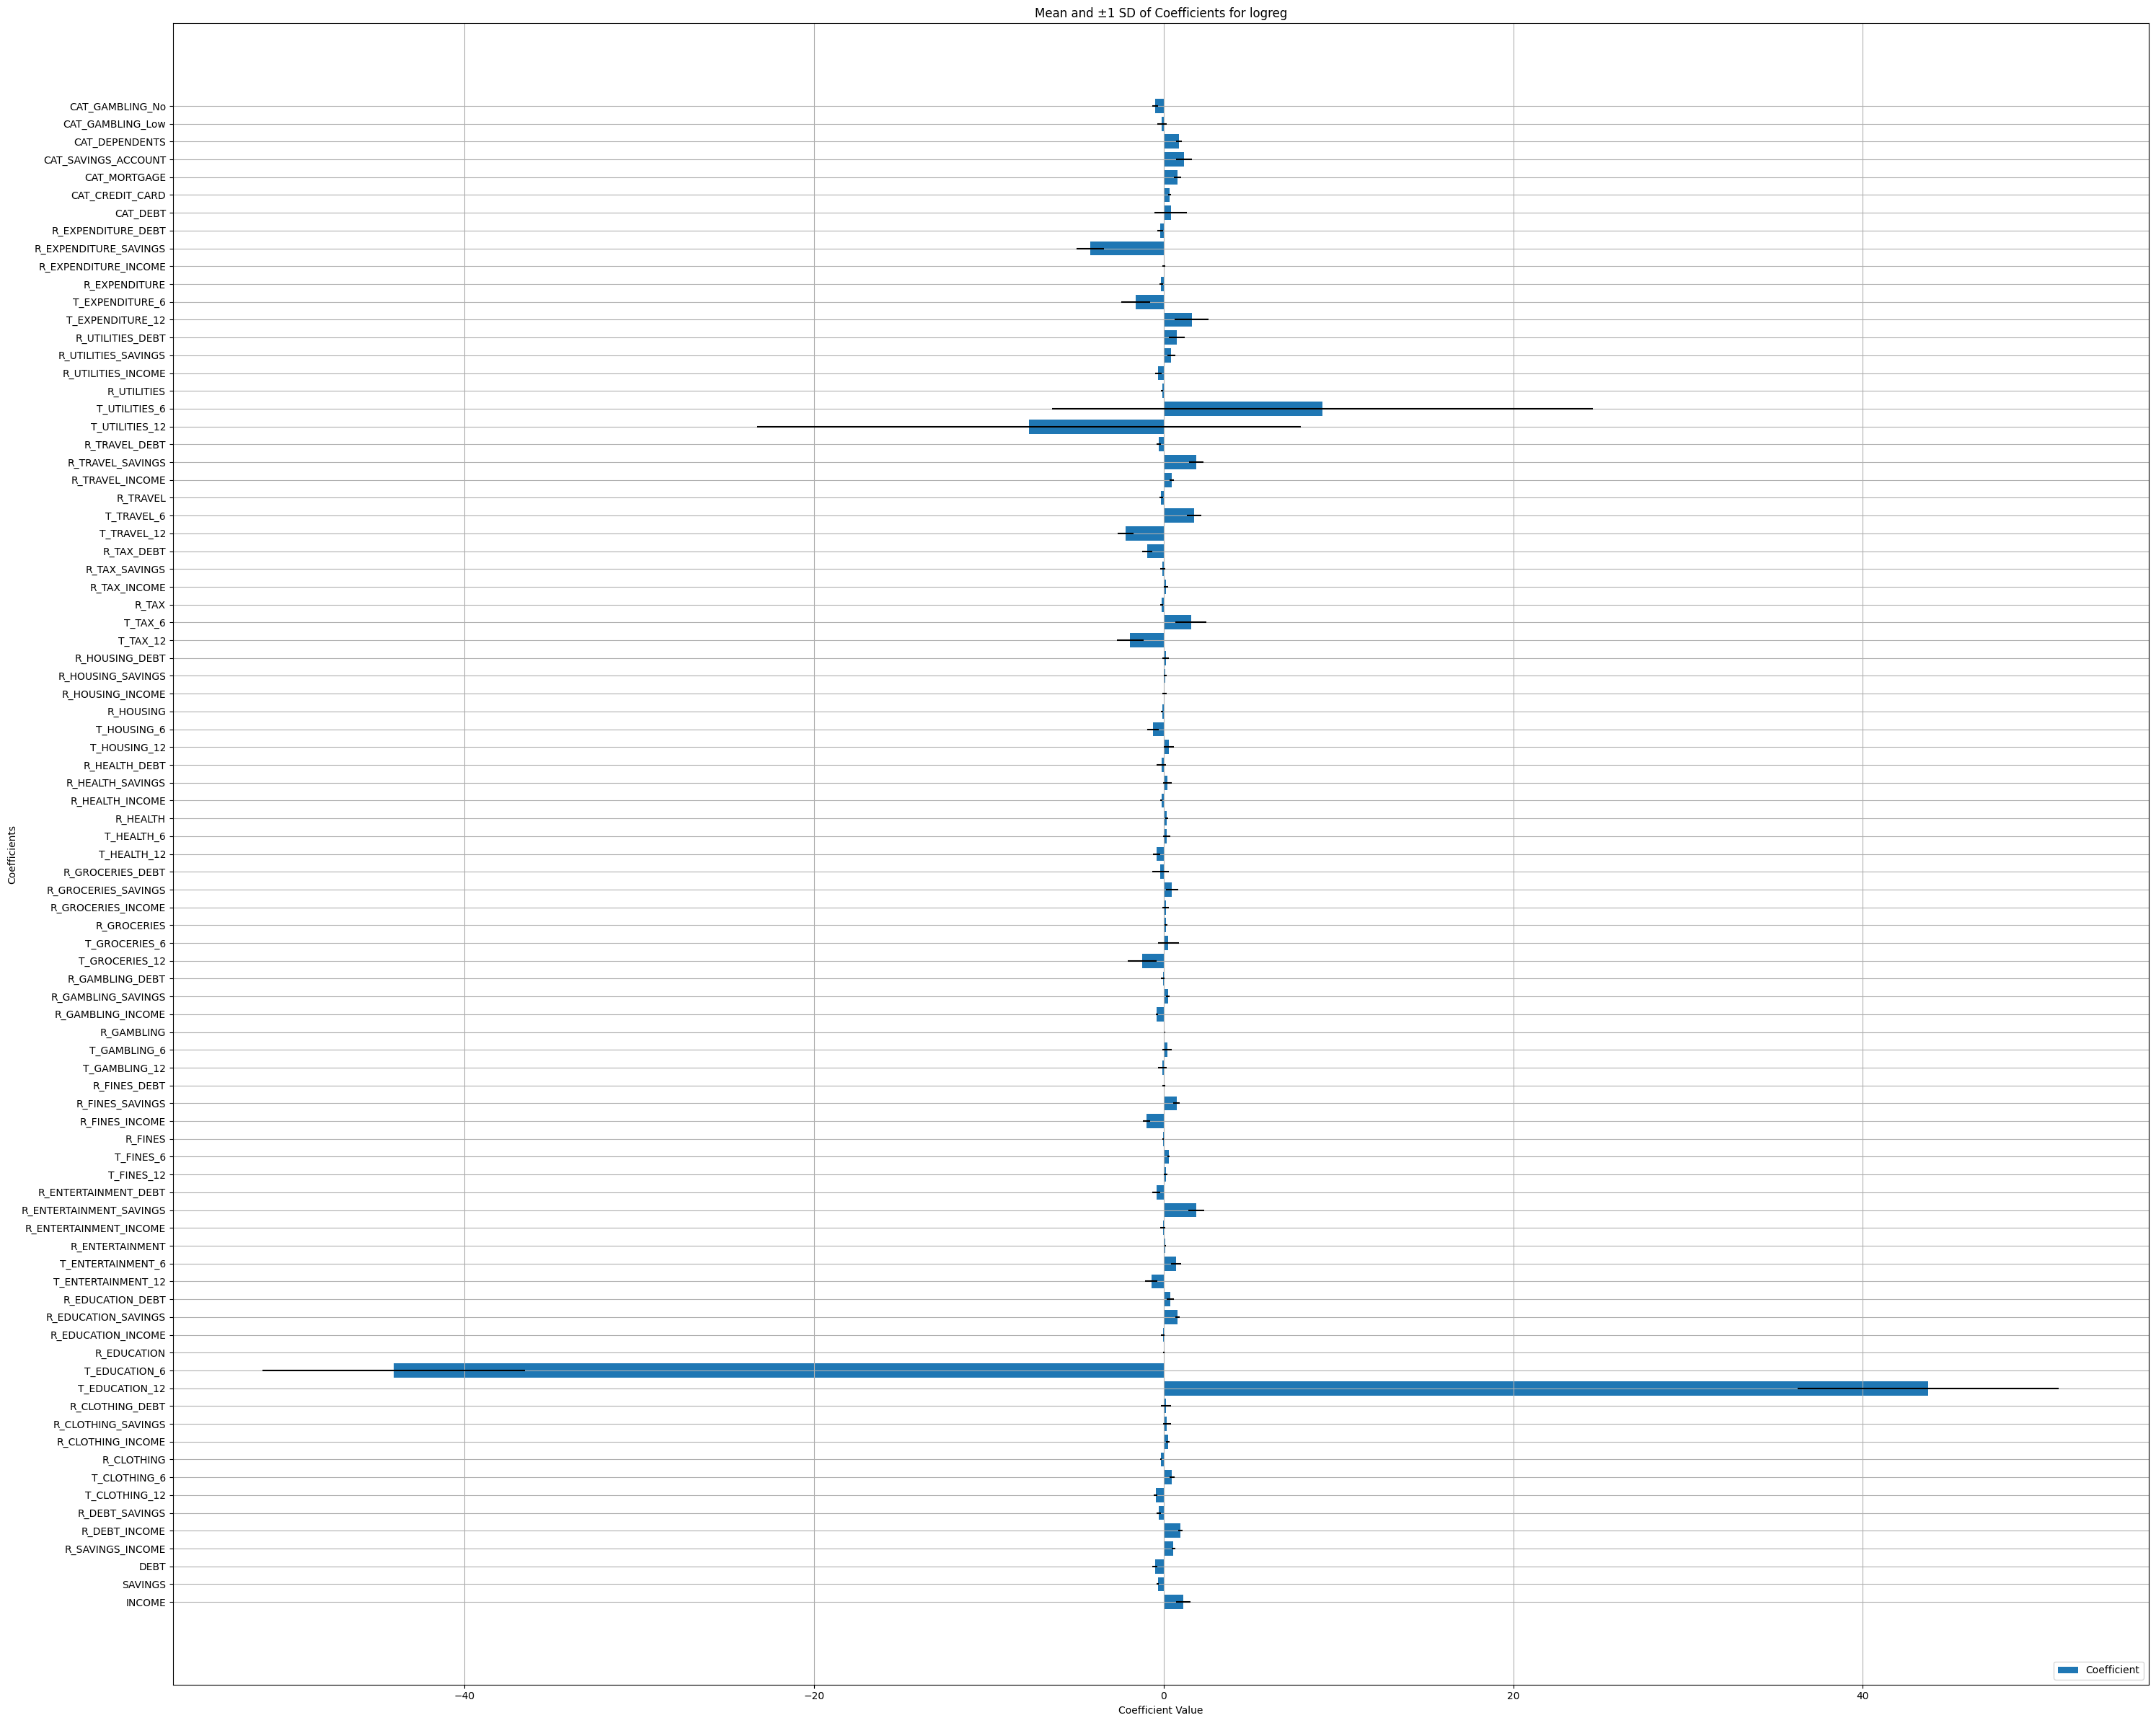

In [27]:
coefficients = {'logreg': []}

for i_ in range(n_splits):
    
    t_start = time.time()
    np.random.seed(5227)
    np.random.shuffle(indices)
    train_inds = indices[:n_train]
    test_inds = indices[n_train:]
    X_train = X_w_dummies.iloc[train_inds, :].copy()
    X_test = X_w_dummies.iloc[test_inds, :].copy()
    Y_train = Y_default.iloc[train_inds]
    Y_test = Y_default.iloc[test_inds]
    for key in columns_to_normalize:
        x_mean = X_train[key].mean()
        x_std = X_train[key].std()
        X_train.loc[:, key] = (X_train[key] - x_mean) / x_std
        X_test.loc[:, key] = (X_test[key] - x_mean) / x_std
    
    clf = LogisticRegression(penalty=None, max_iter=10000)
    clf.fit(X_train, Y_train)
    coefficients['logreg'].append(clf.coef_[0])
    #print(f"Finished split {i_}")
    #print("This split took: %.2f secs" % t_elapsed)

means_stds = {model: (np.mean(coeffs, axis=0), np.std(coeffs, axis=0)) for model, coeffs in coefficients.items()}

for model, (means_, stds_) in means_stds.items():
    plt.figure(figsize=(30, 24))
    y_pos = range(len(means_))
    plt.barh(y=y_pos, width=means_, xerr=stds_, align='center')
    plt.yticks(y_pos, X_train.columns)
    plt.title(f'Mean and ±1 SD of Coefficients for {model}')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Coefficients')
    plt.legend(['Coefficient'], loc='lower right')
    plt.tight_layout()
    plt.grid(True)
    plt.show()

Finished split 0
This split took: 18.36 secs
Finished split 1
This split took: 12.96 secs
Finished split 2
This split took: 18.87 secs
Finished split 3
This split took: 18.70 secs
Finished split 4
This split took: 18.43 secs
Finished split 5
This split took: 18.00 secs
Finished split 6
This split took: 20.17 secs
Finished split 7
This split took: 16.78 secs
Finished split 8
This split took: 12.28 secs
Finished split 9
This split took: 18.37 secs


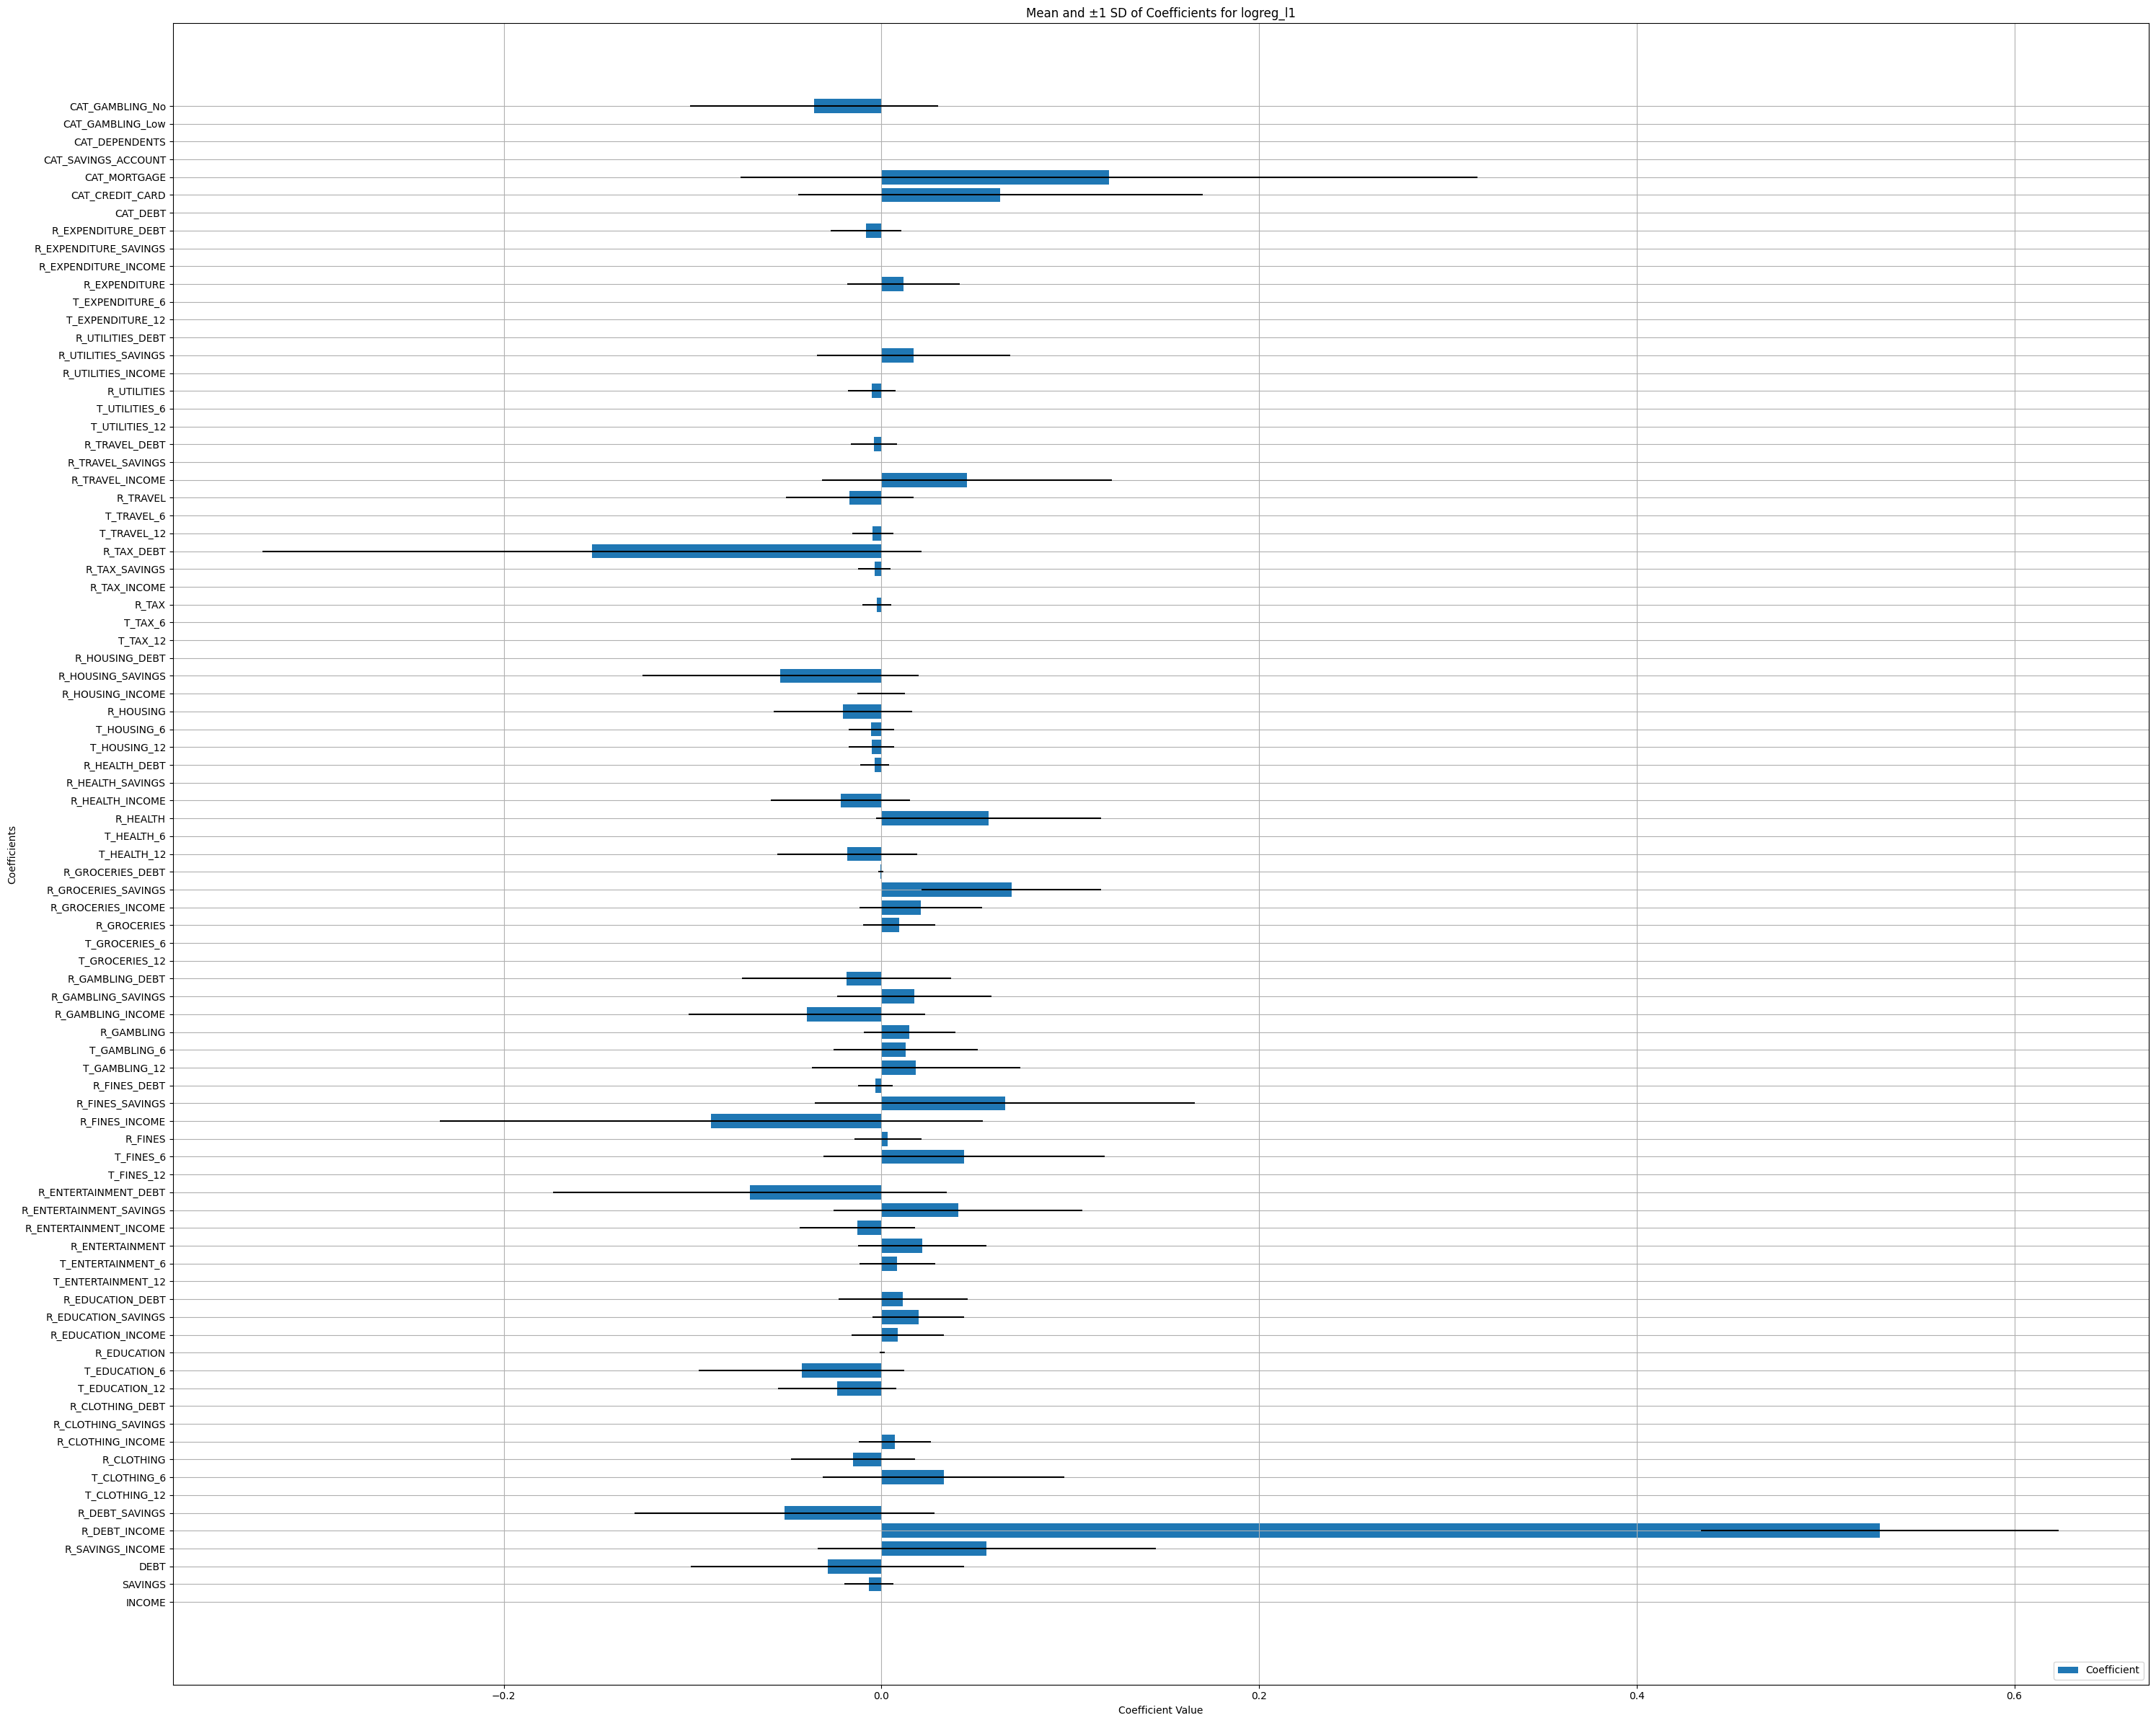

In [28]:
coefficients = {'logreg_l1': []}

for i_ in range(n_splits):
    
    t_start = time.time()    
    np.random.shuffle(indices)
    np.random.seed(5227)
    train_inds = indices[:n_train]
    test_inds = indices[n_train:]
    X_train = X_w_dummies.iloc[train_inds, :].copy()
    X_test = X_w_dummies.iloc[test_inds, :].copy()
    Y_train = Y_default.iloc[train_inds]
    Y_test = Y_default.iloc[test_inds]
    for key in columns_to_normalize:
        x_mean = X_train[key].mean()
        x_std = X_train[key].std()
        X_train.loc[:, key] = (X_train[key] - x_mean) / x_std
        X_test.loc[:, key] = (X_test[key] - x_mean) / x_std
    
    clf = LogisticRegressionCV(penalty='l1', solver='saga', max_iter=10000)
    clf.fit(X_train, Y_train)
    coefficients['logreg_l1'].append(clf.coef_[0])
    print(f"Finished split {i_}")
    t_elapsed = time.time() - t_start
    print("This split took: %.2f secs" % t_elapsed)

means_stds = {model: (np.mean(coeffs, axis=0), np.std(coeffs, axis=0)) for model, coeffs in coefficients.items()}

for model, (means_, stds_) in means_stds.items():
    plt.figure(figsize=(30, 24))
    y_pos = range(len(means_))
    plt.barh(y=y_pos, width=means_, xerr=stds_, align='center')
    plt.yticks(y_pos, X_train.columns)
    plt.title(f'Mean and ±1 SD of Coefficients for {model}')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Coefficients')
    plt.legend(['Coefficient'], loc='lower right')
    plt.tight_layout()
    plt.grid(True)
    plt.show()

Finished split 0
This split took: 2.15 secs
Finished split 1
This split took: 1.41 secs
Finished split 2
This split took: 1.58 secs
Finished split 3
This split took: 1.07 secs
Finished split 4
This split took: 1.17 secs
Finished split 5
This split took: 1.40 secs
Finished split 6
This split took: 1.88 secs
Finished split 7
This split took: 1.16 secs
Finished split 8
This split took: 1.25 secs
Finished split 9
This split took: 1.26 secs


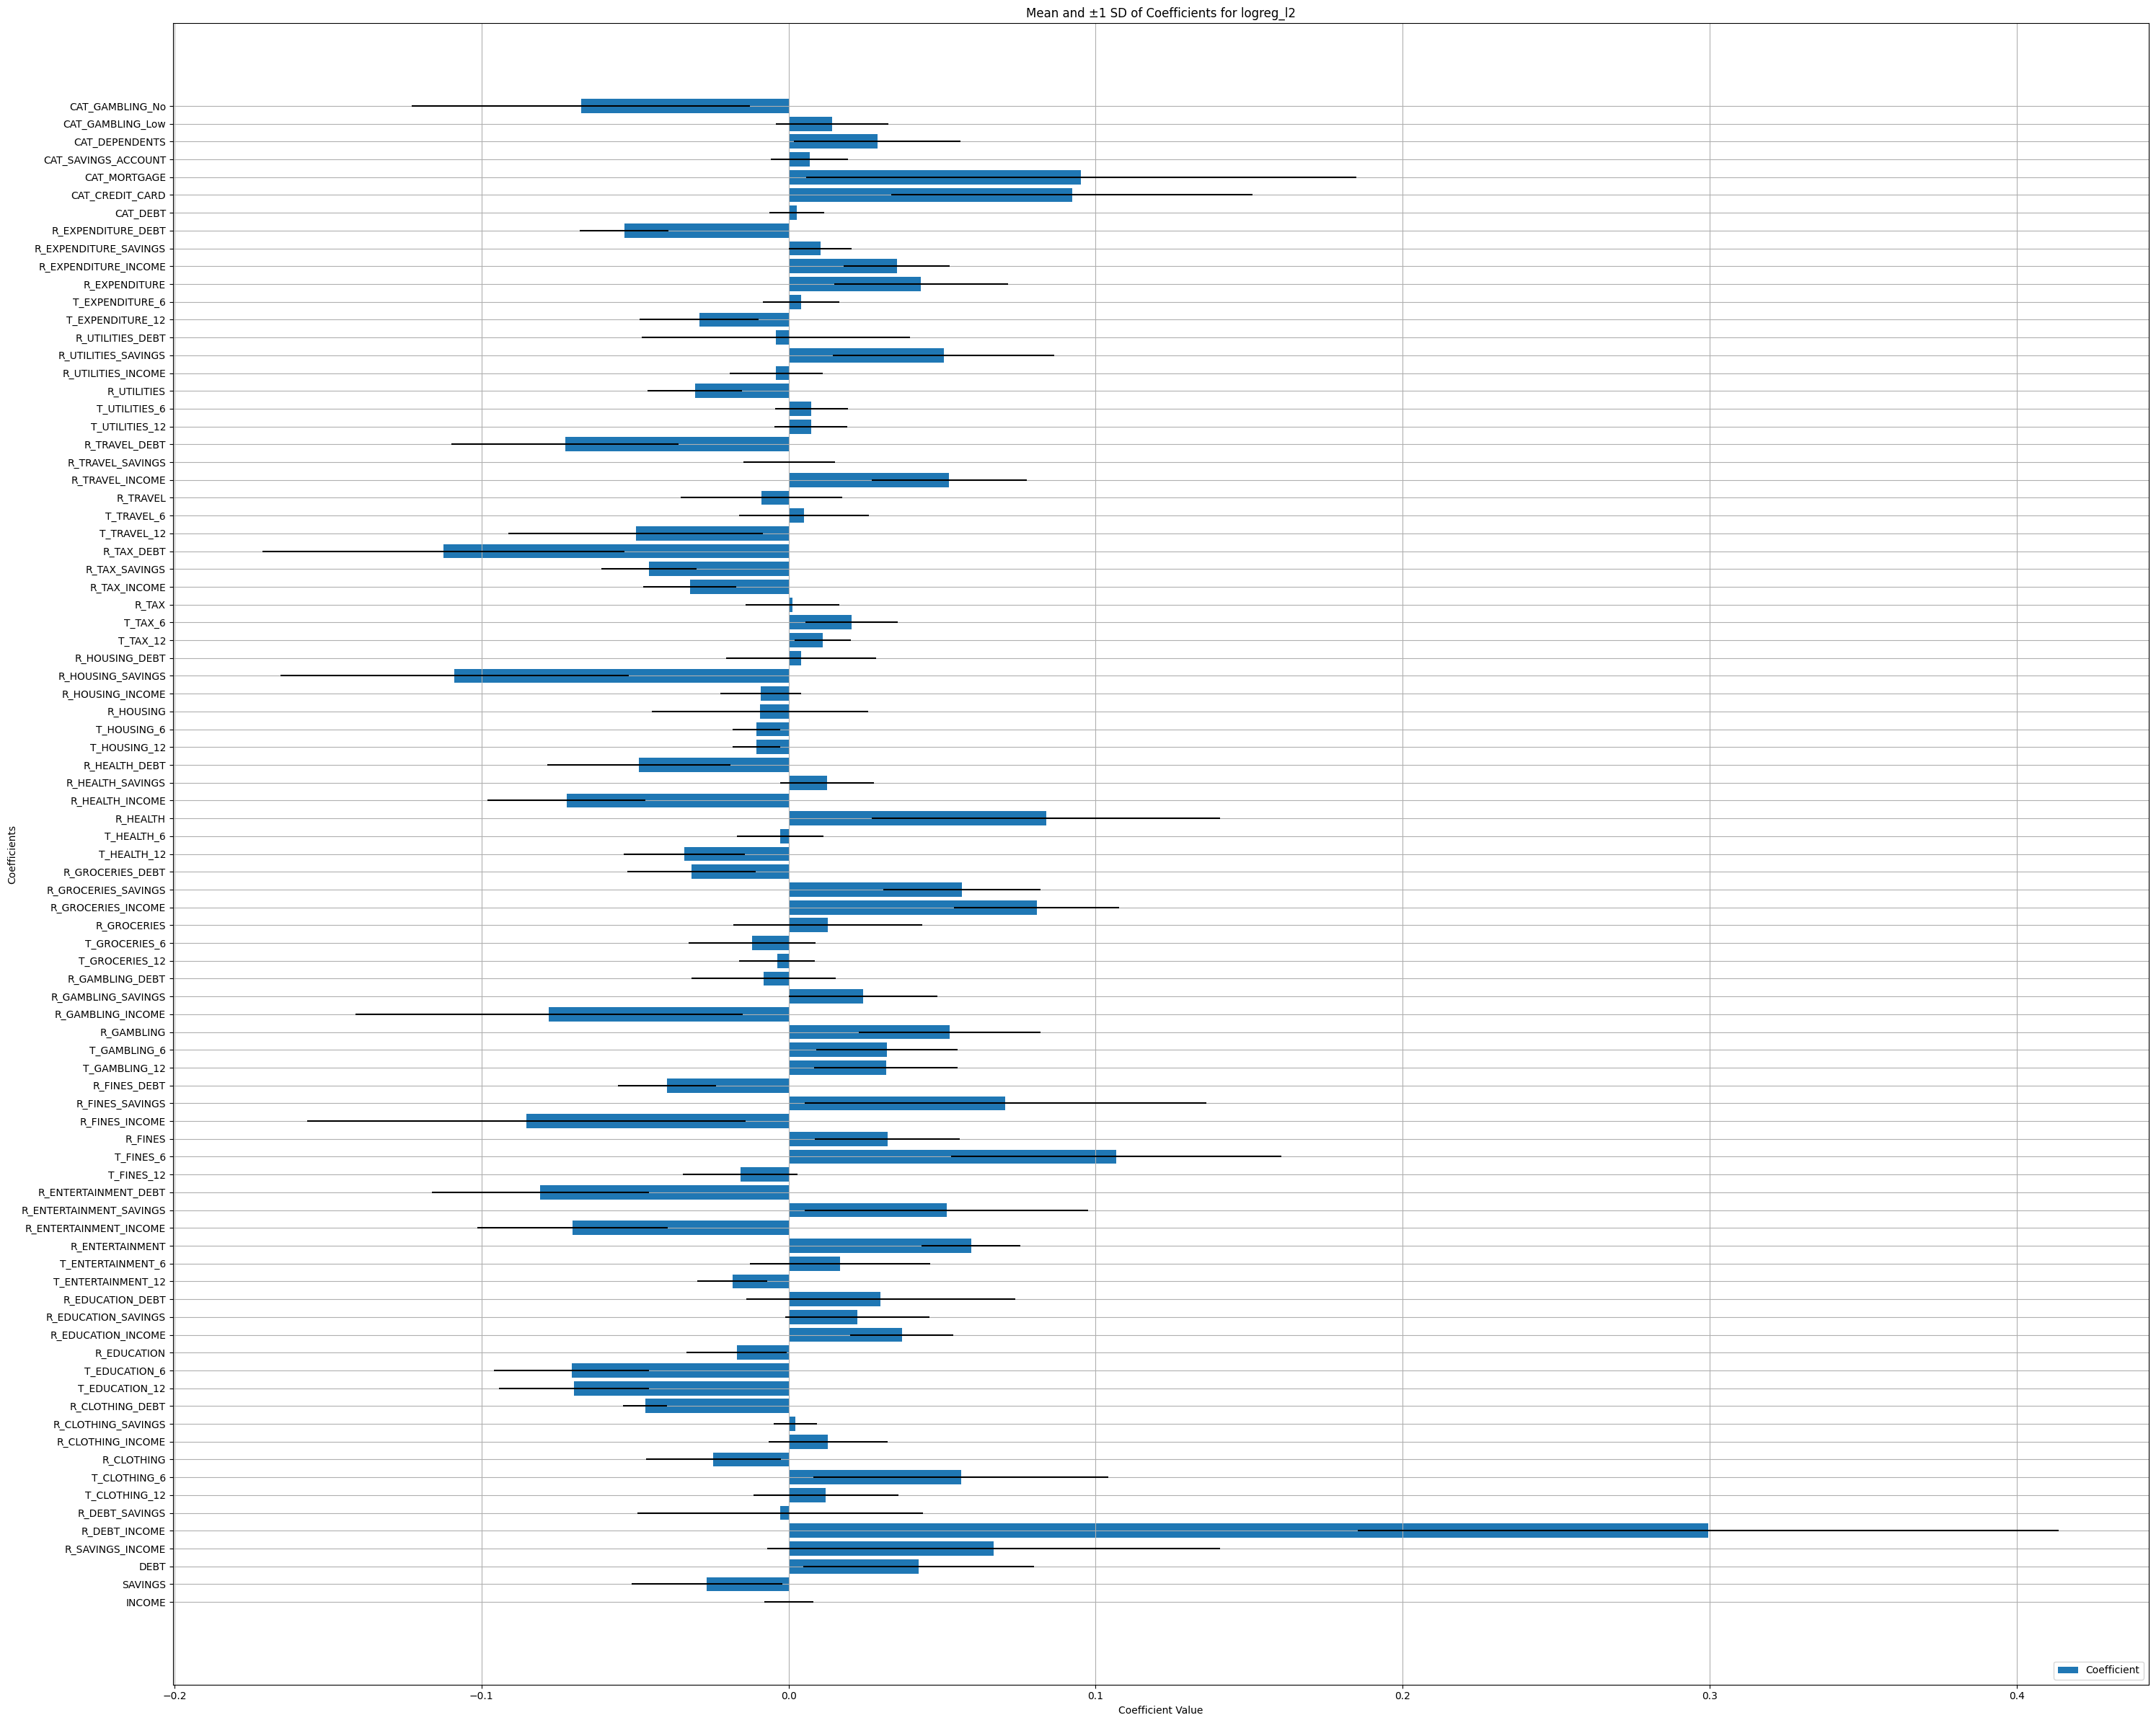

In [29]:
coefficients = {'logreg_l2': []}

for i_ in range(n_splits):
    
    t_start = time.time()
    np.random.seed(5227)
    np.random.shuffle(indices)
    train_inds = indices[:n_train]
    test_inds = indices[n_train:]
    X_train = X_w_dummies.iloc[train_inds, :].copy()
    X_test = X_w_dummies.iloc[test_inds, :].copy()
    Y_train = Y_default.iloc[train_inds]
    Y_test = Y_default.iloc[test_inds]
    
    for key in columns_to_normalize:
        x_mean = X_train[key].mean()
        x_std = X_train[key].std()
        X_train.loc[:, key] = (X_train[key] - x_mean) / x_std
        X_test.loc[:, key] = (X_test[key] - x_mean) / x_std
    
    clf = LogisticRegressionCV(penalty='l2', max_iter=10000)
    clf.fit(X_train, Y_train)
    coefficients['logreg_l2'].append(clf.coef_[0])
    print(f"Finished split {i_}")
    t_elapsed = time.time() - t_start
    print("This split took: %.2f secs" % t_elapsed)

means_stds = {model: (np.mean(coeffs, axis=0), np.std(coeffs, axis=0)) for model, coeffs in coefficients.items()}

for model, (means_, stds_) in means_stds.items():
    plt.figure(figsize=(30, 24))
    y_pos = range(len(means_))
    plt.barh(y=y_pos, width=means_, xerr=stds_, align='center')
    plt.yticks(y_pos, X_train.columns)
    plt.title(f'Mean and ±1 SD of Coefficients for {model}')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Coefficients')
    plt.legend(['Coefficient'], loc='lower right')
    plt.tight_layout()
    plt.grid(True)
    plt.show()

Here are the plots of horizontal barplot with ± one standard deviation bar for default.

According to the results from Logistic Regression, R_EXPENDITURE_SAVINGS, T_UTILITIES_6, T_UTILITIES_12, T_EDUCATION_6, T_EDUCATION_12 has a negative or positive high coefficient. Among these features, R_EXPENDITURE_SAVINGS, T_EDUCATION_6, and T_EDUCATION_12 have low standard deviations. Consequently, R_EXPENDITURE_SAVINGS, T_EDUCATION_6, and T_EDUCATION_12 have relatively higher coefficients and magnitudes, and higher certainty in the case.

According to the results from Logistic Regression (l1), only R_DEBT_INCOME has a negative or positive high coefficient and also low standard deviations. Consequently, R_DEBT_INCOME has relatively higher coefficients and magnitudes, and higher certainty in the case. 

According to the results from Logistic Regression (l2), CAT_GAMBLING_No, CAT_CREDIT_CARD, R_EXPENDITURE_INCOME, T_EXPENDITURE_12, R_TRAVEL_INCOME, R_TAX_DEBT, R_HOUSINGG_SACINGS, R_HEALTH_INCOME, R_GROCERIES_INCOME, T_FINES_6, T_EDUCATION_6, T_EDUCATION_12, R_DEBT_INCOME have relatively higher coefficients and magnitudes, and higher certainty in the case. Consequently, CAT_GAMBLING_NO CAT_CREDIT_CARD, R_EXPENDITURE_INCOME, T_EXPENDITURE_12, R_TRAVEL_INCOME, R_TAX_DEBT, R_HOUSINGG_SACINGS, R_HEALTH_INCOME, R_GROCERIES_INCOME, T_FINES_6, T_EDUCATION_6, T_EDUCATION_12, R_DEBT_INCOME have relatively higher coefficients and magnitudes, and higher certainty in the case.

Finished split 0
This split took: 0.30 secs
Finished split 1
This split took: 0.29 secs
Finished split 2
This split took: 0.41 secs
Finished split 3
This split took: 0.37 secs
Finished split 4
This split took: 0.27 secs
Finished split 5
This split took: 0.55 secs
Finished split 6
This split took: 0.38 secs
Finished split 7
This split took: 0.43 secs
Finished split 8
This split took: 0.29 secs
Finished split 9
This split took: 0.42 secs


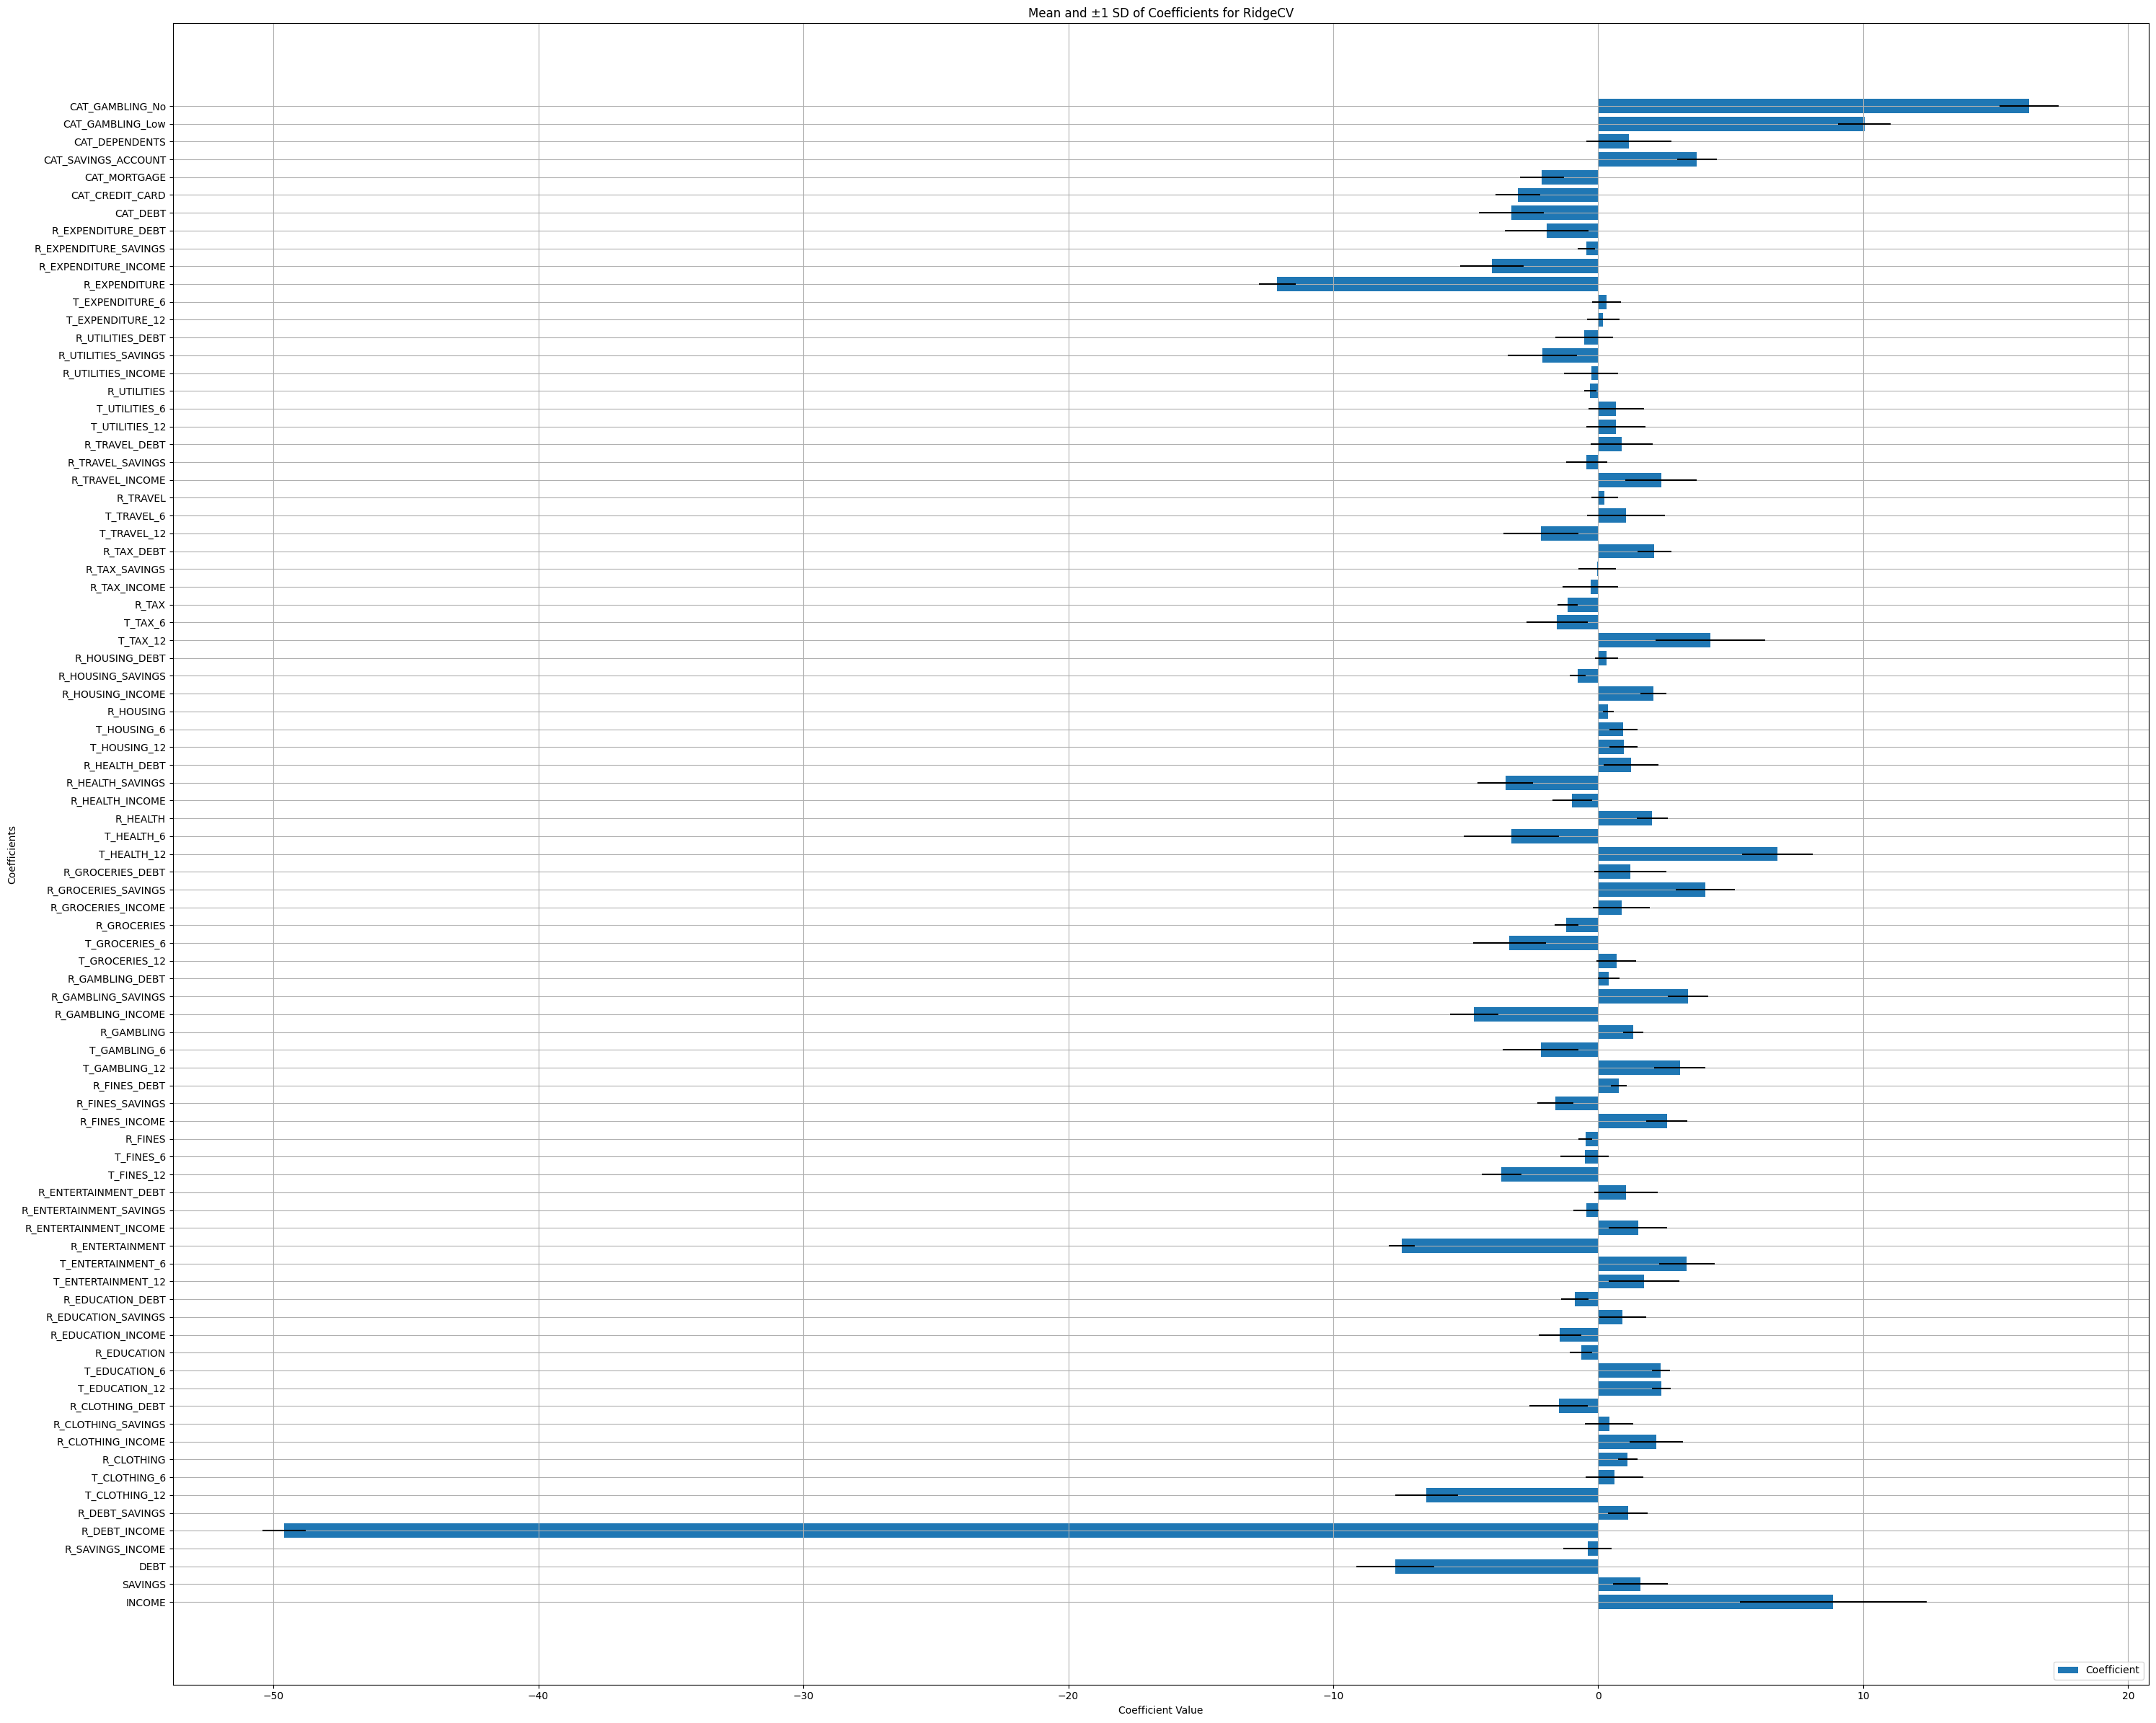

In [30]:
n_splits = 10  # number of cross validation splits

indices = list(range(X_w_dummies.shape[0]))
n_train = int(len(indices) * .85)  # 85% train, 15% split

coefficients = {'RidgeCV': []}

for i_ in range(n_splits):
    
    t_start = time.time()
    np.random.seed(5227)
    np.random.shuffle(indices)
    train_inds = indices[:n_train]
    test_inds = indices[n_train:]
    X_train = X_w_dummies.iloc[train_inds, :].copy()
    X_test = X_w_dummies.iloc[test_inds, :].copy()
    Y_train = Y_credit.iloc[train_inds]
    Y_test = Y_credit.iloc[test_inds]
    for key in columns_to_normalize:
        x_mean = X_train[key].mean()
        x_std = X_train[key].std()
        X_train.loc[:, key] = (X_train[key] - x_mean) / x_std
        X_test.loc[:, key] = (X_test[key] - x_mean) / x_std
    
    model = RidgeCV()  # uses 5-fold cross validation by default
    model.fit(X_train, Y_train)
    coefficients['RidgeCV'].append(model.coef_)
    print(f"Finished split {i_}")
    t_elapsed = time.time() - t_start
    print("This split took: %.2f secs" % t_elapsed)

means_stds = {model: (np.mean(coeffs, axis=0), np.std(coeffs, axis=0)) for model, coeffs in coefficients.items()}

for model, (means_, stds_) in means_stds.items():
    plt.figure(figsize=(30, 24))
    y_pos = range(len(means_))
    plt.barh(y=y_pos, width=means_, xerr=stds_, align='center')
    plt.yticks(y_pos, X_train.columns)
    plt.title(f'Mean and ±1 SD of Coefficients for {model}')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Coefficients')
    plt.legend(['Coefficient'], loc='lower right')
    plt.tight_layout()
    plt.grid(True)
    plt.show()

In [31]:
for model, (means_, stds_) in means_stds.items():
    high_mean_threshold = np.percentile(means_, 75)
    low_std_threshold = np.percentile(stds_, 25)
    high_mean_low_std_coeffs = [(X_train.columns[i], means_[i], stds_[i]) 
                                for i, (mean, std) in enumerate(zip(means_, stds_))
                                if mean > high_mean_threshold and std < low_std_threshold]
    print(f"Model: {model}")
    if high_mean_low_std_coeffs:
        print("Coefficients with high mean and low std:")
        for coeff in high_mean_low_std_coeffs:
            print(f"Coefficient: {coeff[0]}, Mean: {coeff[1]:.4f}, Std: {coeff[2]:.4f}")
    else:
        print("No coefficients meet the criteria.")
    print() 

Model: RidgeCV
Coefficients with high mean and low std:
Coefficient: T_EDUCATION_12, Mean: 2.3701, Std: 0.3534
Coefficient: T_EDUCATION_6, Mean: 2.3631, Std: 0.3379
Coefficient: R_HOUSING_INCOME, Mean: 2.0858, Std: 0.4850



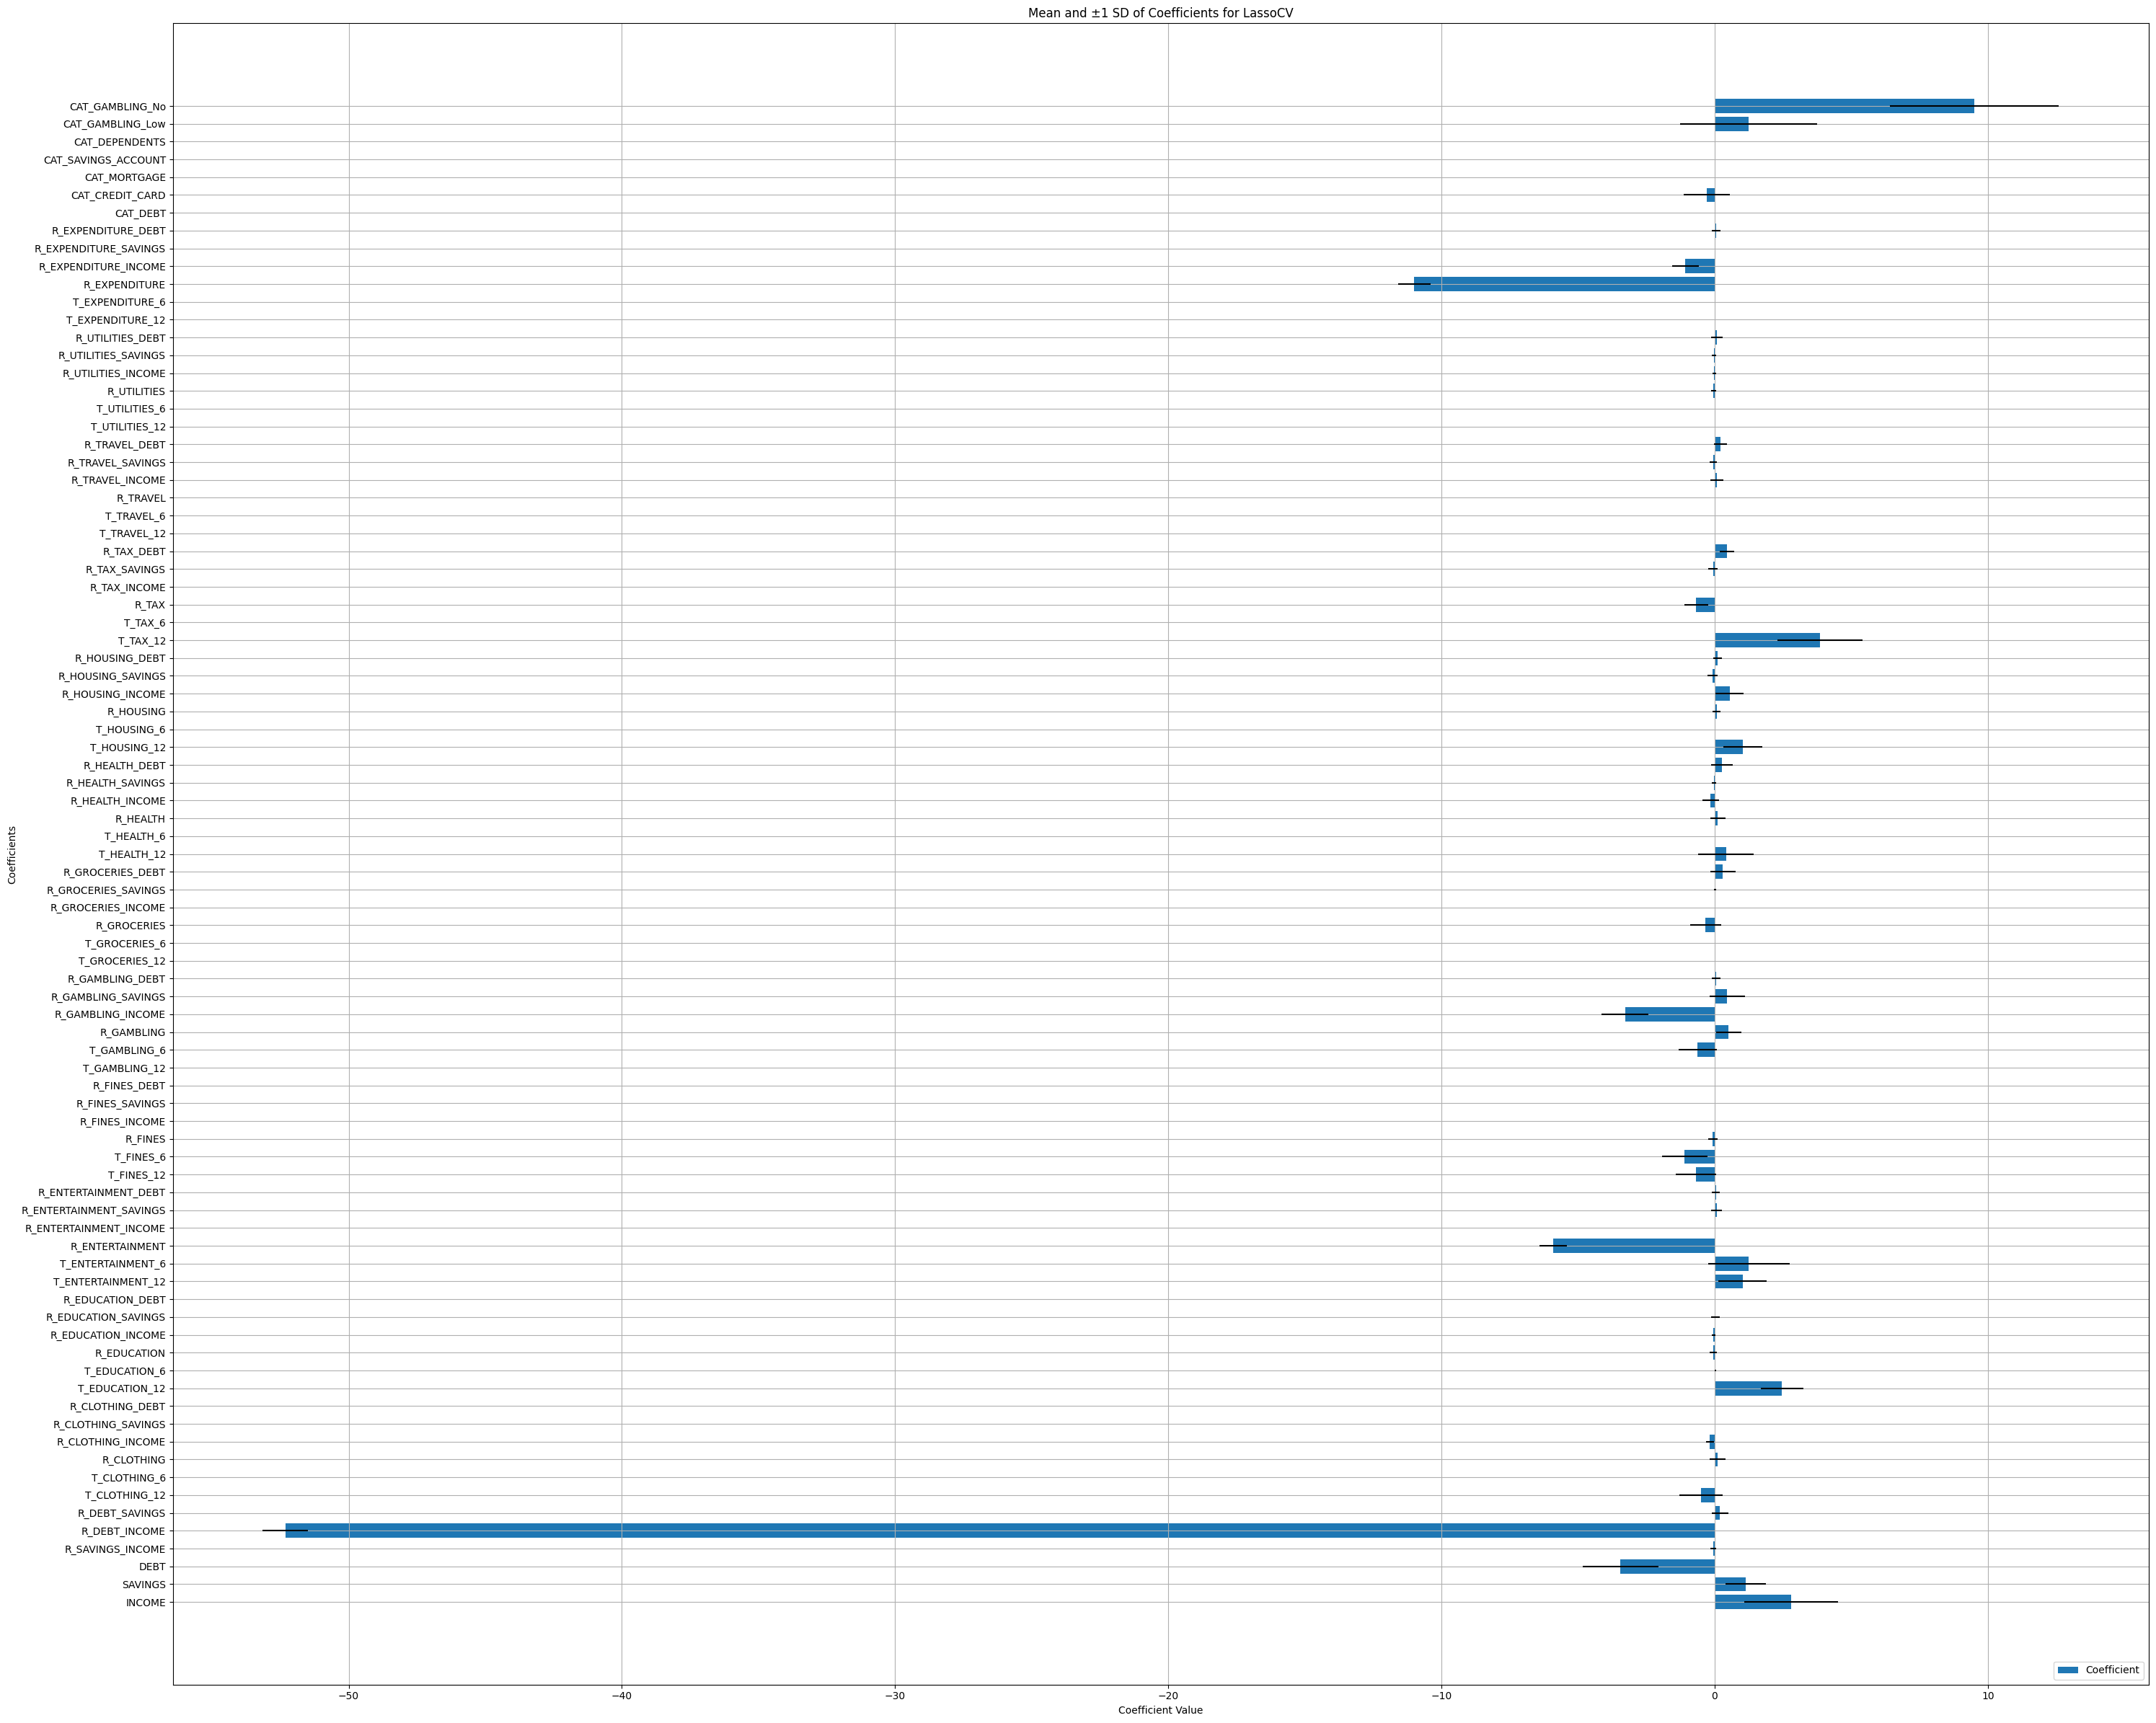

In [32]:
coefficients = {'LassoCV': []}

for i_ in range(n_splits):
    
    t_start = time.time()  
    np.random.seed(5227)
    np.random.shuffle(indices)
    train_inds = indices[:n_train]
    test_inds = indices[n_train:]
    X_train = X_w_dummies.iloc[train_inds, :].copy()
    X_test = X_w_dummies.iloc[test_inds, :].copy()
    Y_train = Y_credit.iloc[train_inds]
    Y_test = Y_credit.iloc[test_inds]
    for key in columns_to_normalize:
        x_mean = X_train[key].mean()
        x_std = X_train[key].std()
        X_train.loc[:, key] = (X_train[key] - x_mean) / x_std
        X_test.loc[:, key] = (X_test[key] - x_mean) / x_std
    
    model = LassoCV(max_iter=2000)
    model.fit(X_train, Y_train)
    coefficients['LassoCV'].append(model.coef_)
    #print(f"Finished split {i_}")
    #print("This split took: %.2f secs" % t_elapsed)

means_stds = {model: (np.mean(coeffs, axis=0), np.std(coeffs, axis=0)) for model, coeffs in coefficients.items()}

for model, (means_, stds_) in means_stds.items():
    plt.figure(figsize=(30, 24))
    y_pos = range(len(means_))
    plt.barh(y=y_pos, width=means_, xerr=stds_, align='center')
    plt.yticks(y_pos, X_train.columns)
    plt.title(f'Mean and ±1 SD of Coefficients for {model}')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Coefficients')
    plt.legend(['Coefficient'], loc='lower right')
    plt.tight_layout()
    plt.grid(True)
    plt.show()

In [33]:
for model, (means_, stds_) in means_stds.items():
    high_mean_threshold = np.percentile(means_, 65)
    low_std_threshold = np.percentile(stds_, 35)
    high_mean_low_std_coeffs = [(X_train.columns[i], means_[i], stds_[i]) 
                                for i, (mean, std) in enumerate(zip(means_, stds_))
                                if mean > high_mean_threshold and std < low_std_threshold]
    print(f"Model: {model}")
    if high_mean_low_std_coeffs:
        print("Coefficients with high mean and low std:")
        for coeff in high_mean_low_std_coeffs:
            print(f"Coefficient: {coeff[0]}, Mean: {coeff[1]:.4f}, Std: {coeff[2]:.4f}")
    else:
        print("No coefficients meet the criteria.")
    print() 

Model: LassoCV
Coefficients with high mean and low std:
Coefficient: T_EDUCATION_6, Mean: 0.0201, Std: 0.0270



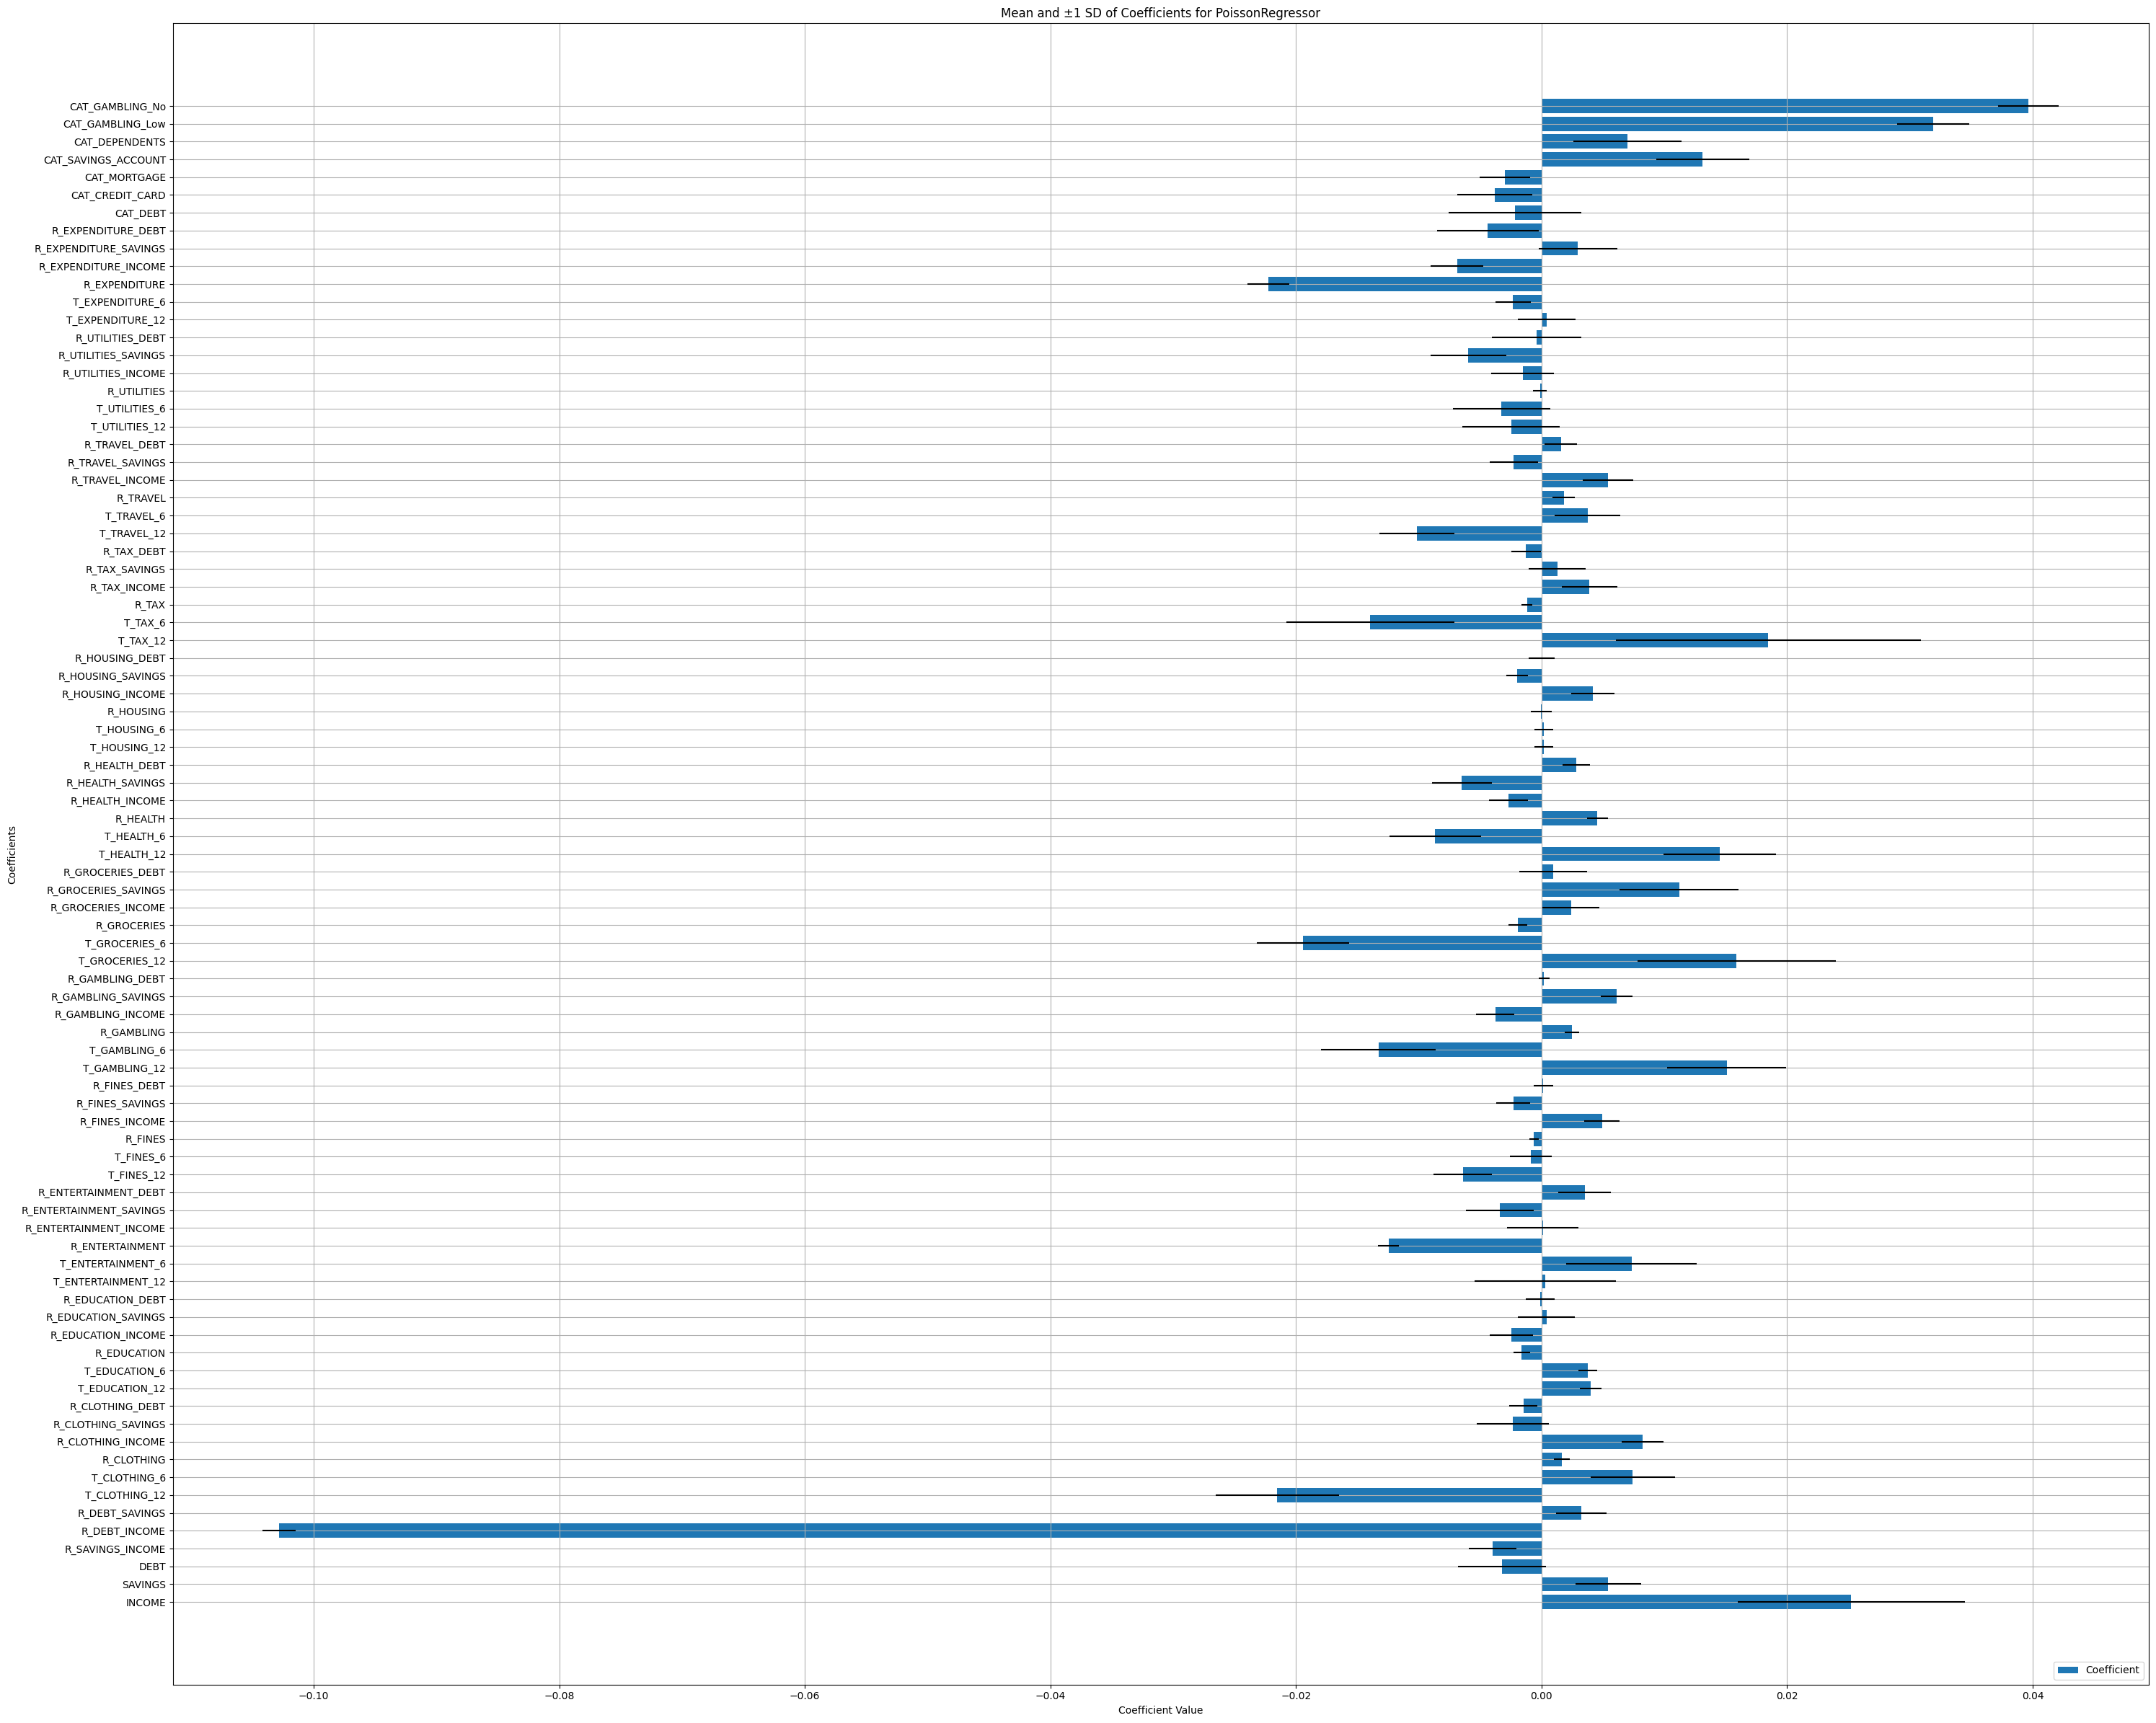

In [34]:
coefficients = {'PoissonRegressor': []}

for i_ in range(n_splits):
    
    t_start = time.time()
    np.random.seed(5227)
    np.random.shuffle(indices)
    train_inds = indices[:n_train]
    test_inds = indices[n_train:]
    X_train = X_w_dummies.iloc[train_inds, :].copy()
    X_test = X_w_dummies.iloc[test_inds, :].copy()
    Y_train = Y_credit.iloc[train_inds]
    Y_test = Y_credit.iloc[test_inds]
    for key in columns_to_normalize:
        x_mean = X_train[key].mean()
        x_std = X_train[key].std()
        X_train.loc[:, key] = (X_train[key] - x_mean) / x_std
        X_test.loc[:, key] = (X_test[key] - x_mean) / x_std
    
    model = PoissonRegressor(max_iter=10000)
    model.fit(X_train, Y_train)
    coefficients['PoissonRegressor'].append(model.coef_)
    #print(f"Finished split {i_}")
    #print("This split took: %.2f secs" % t_elapsed)

means_stds = {model: (np.mean(coeffs, axis=0), np.std(coeffs, axis=0)) for model, coeffs in coefficients.items()}

for model, (means_, stds_) in means_stds.items():
    plt.figure(figsize=(30, 24))
    y_pos = range(len(means_))
    plt.barh(y=y_pos, width=means_, xerr=stds_, align='center')
    plt.yticks(y_pos, X_train.columns)
    plt.title(f'Mean and ±1 SD of Coefficients for {model}')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Coefficients')
    plt.legend(['Coefficient'], loc='lower right')
    plt.tight_layout()
    plt.grid(True)
    plt.show()

In [35]:
for model, (means_, stds_) in means_stds.items():
    high_mean_threshold = np.percentile(means_, 75)
    low_std_threshold = np.percentile(stds_, 25)
    high_mean_low_std_coeffs = [(X_train.columns[i], means_[i], stds_[i]) 
                                for i, (mean, std) in enumerate(zip(means_, stds_))
                                if mean > high_mean_threshold and std < low_std_threshold]
    print(f"Model: {model}")
    if high_mean_low_std_coeffs:
        print("Coefficients with high mean and low std:")
        for coeff in high_mean_low_std_coeffs:
            print(f"Coefficient: {coeff[0]}, Mean: {coeff[1]:.4f}, Std: {coeff[2]:.4f}")
    else:
        print("No coefficients meet the criteria.")
    print() 

Model: PoissonRegressor
Coefficients with high mean and low std:
Coefficient: T_EDUCATION_12, Mean: 0.0040, Std: 0.0009
Coefficient: R_HEALTH, Mean: 0.0046, Std: 0.0008



Finished split 0
Finished split 1
Finished split 2
Finished split 3
Finished split 4
Finished split 5
Finished split 6
Finished split 7
Finished split 8
Finished split 9


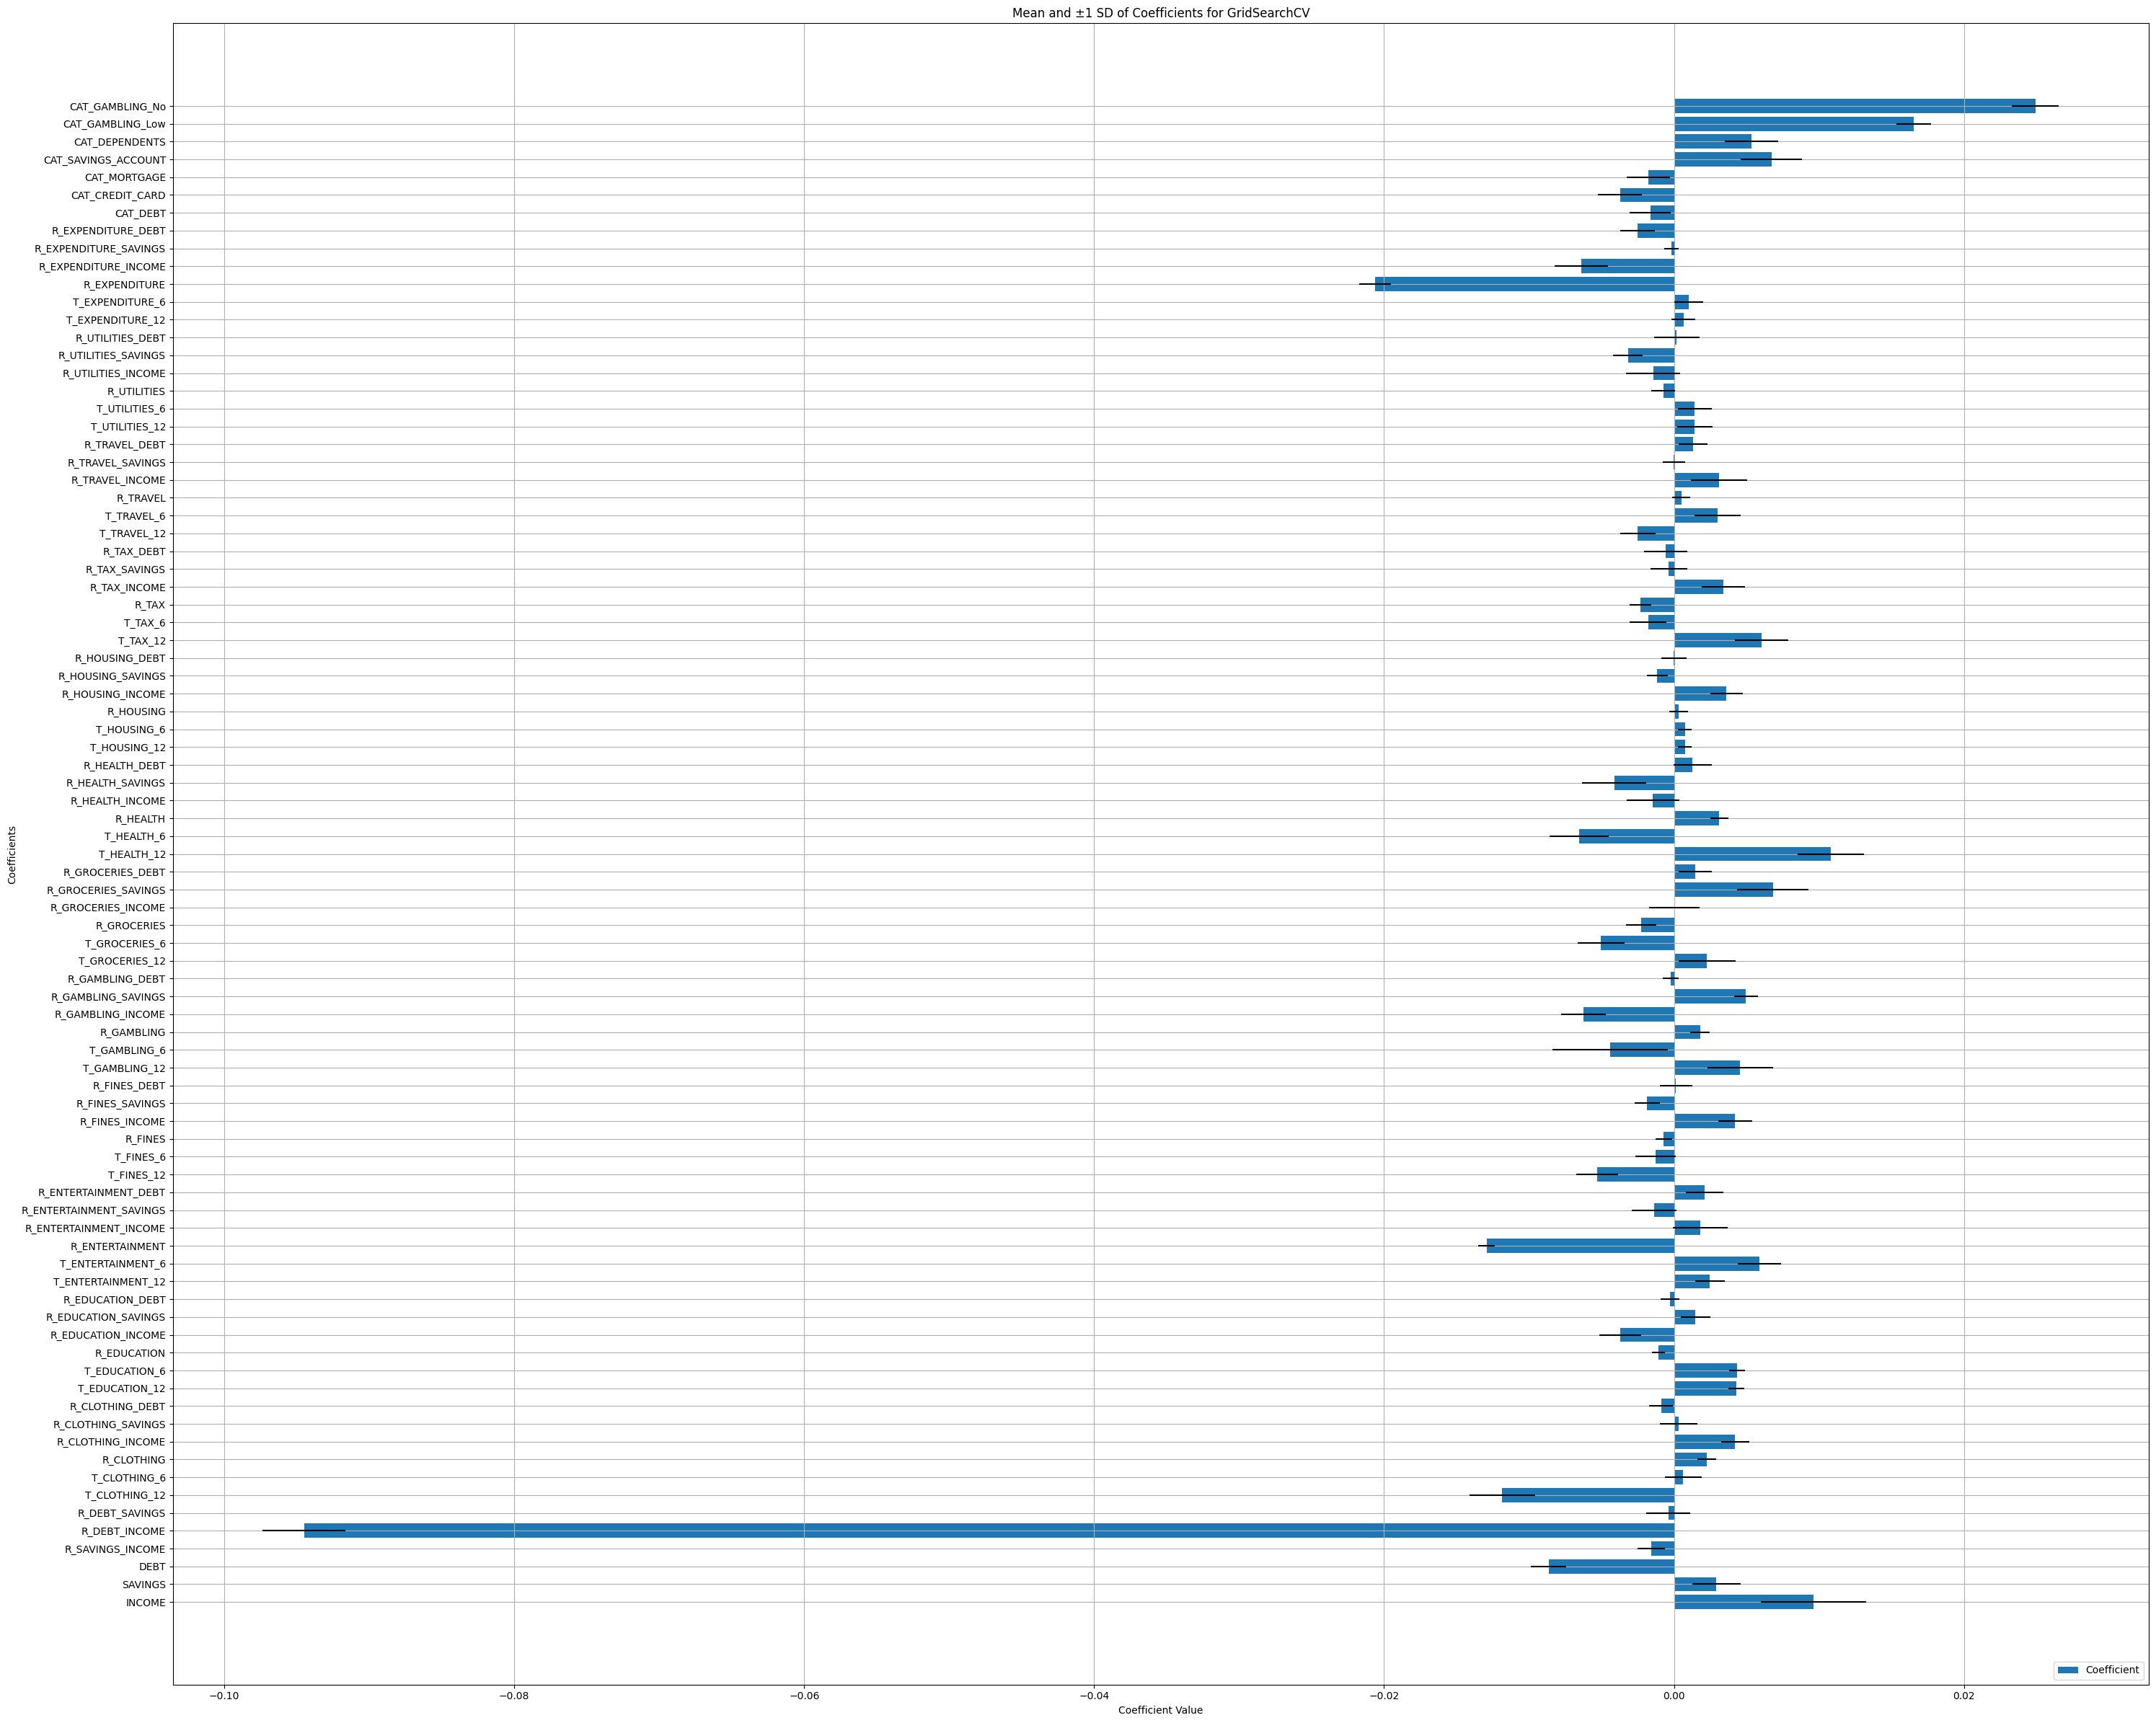

In [36]:
coefficients = {'GridSearchCV': []}

for i_ in range(n_splits):
    
    t_start = time.time()
    np.random.seed(5227)
    np.random.shuffle(indices)
    train_inds = indices[:n_train]
    test_inds = indices[n_train:]
    X_train = X_w_dummies.iloc[train_inds, :].copy()
    X_test = X_w_dummies.iloc[test_inds, :].copy()
    Y_train = Y_credit.iloc[train_inds]
    Y_test = Y_credit.iloc[test_inds]
    for key in columns_to_normalize:
        x_mean = X_train[key].mean()
        x_std = X_train[key].std()
        X_train.loc[:, key] = (X_train[key] - x_mean) / x_std
        X_test.loc[:, key] = (X_test[key] - x_mean) / x_std
    
    regressor = PoissonRegressor(max_iter=10000)
    model = GridSearchCV(estimator=regressor, param_grid={'alpha': np.linspace(0.1, 10, 10)})  # uses 5-fold cross validation by default
    model.fit(X_train, Y_train)
    coefficients['GridSearchCV'].append(model.best_estimator_.coef_)
    print(f"Finished split {i_}")
    #print("This split took: %.2f secs" % t_elapsed)

means_stds = {model: (np.mean(coeffs, axis=0), np.std(coeffs, axis=0)) for model, coeffs in coefficients.items()}

for model, (means_, stds_) in means_stds.items():
    plt.figure(figsize=(30, 24))
    y_pos = range(len(means_))
    plt.barh(y=y_pos, width=means_, xerr=stds_, align='center')
    plt.yticks(y_pos, X_train.columns)
    plt.title(f'Mean and ±1 SD of Coefficients for {model}')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Coefficients')
    plt.legend(['Coefficient'], loc='lower right')
    plt.tight_layout()
    plt.grid(True)
    plt.show()

In [37]:
for model, (means_, stds_) in means_stds.items():
    high_mean_threshold = np.percentile(means_, 75)
    low_std_threshold = np.percentile(stds_, 25)
    high_mean_low_std_coeffs = [(X_train.columns[i], means_[i], stds_[i]) 
                                for i, (mean, std) in enumerate(zip(means_, stds_))
                                if mean > high_mean_threshold and std < low_std_threshold]
    print(f"Model: {model}")
    if high_mean_low_std_coeffs:
        print("Coefficients with high mean and low std:")
        for coeff in high_mean_low_std_coeffs:
            print(f"Coefficient: {coeff[0]}, Mean: {coeff[1]:.4f}, Std: {coeff[2]:.4f}")
    else:
        print("No coefficients meet the criteria.")
    print() 

Model: GridSearchCV
Coefficients with high mean and low std:
Coefficient: T_EDUCATION_12, Mean: 0.0043, Std: 0.0006
Coefficient: T_EDUCATION_6, Mean: 0.0043, Std: 0.0006
Coefficient: R_GAMBLING_SAVINGS, Mean: 0.0050, Std: 0.0008
Coefficient: R_HEALTH, Mean: 0.0031, Std: 0.0006



Here are the plots of horizontal barplot with ± one standard deviation bar for default.

According to the results from RidgeCV, T_EDUCATION_12, T_EDUCATION_6, and R_HOUSING_INCOME have relatively higher coefficients and magnitudes, and higher certainty in the case. Consequently, T_EDUCATION_12, T_EDUCATION_6, and R_HOUSING_INCOME have relatively higher coefficients and magnitudes, and higher certainty in the case. 

According to the results from LassoCV, T_EDUCATION_6 has a negative or positive high coefficient and also low standard deviations. Consequently, T_EDUCATION_6 has relatively higher coefficients and magnitudes, and higher certainty in the case.

According to the results from PoissonRegressor, T_EDUCATION_12, and R_HEALTH have a negative or positive high coefficient and also low standard deviations. Consequently, T_EDUCATION_12, and R_HEALTH have relatively higher coefficients and magnitudes, and higher certainty in the case.

According to the results from GridSearchCV, T_EDUCATION_12, T_EDUCATION_6, R_GAMBLING_SAVINGS, and R_HEALTH have a negative or positive high coefficient and also low standard deviations. Consequently, T_EDUCATION_12, T_EDUCATION_6, R_GAMBLING_SAVINGS, and R_HEALTH have relatively higher coefficients and magnitudes, and higher certainty in the case. 

 ### Problem 5 [12 marks]
During our lab in Lecture 4 (on Nonlinear Regression and Splines), we plotted the fit of both polynomial regression and natural cubic splines on the motorcycle dataset, which simulated a motorbike crash for a helmet manufacturer:

<div align="center">
  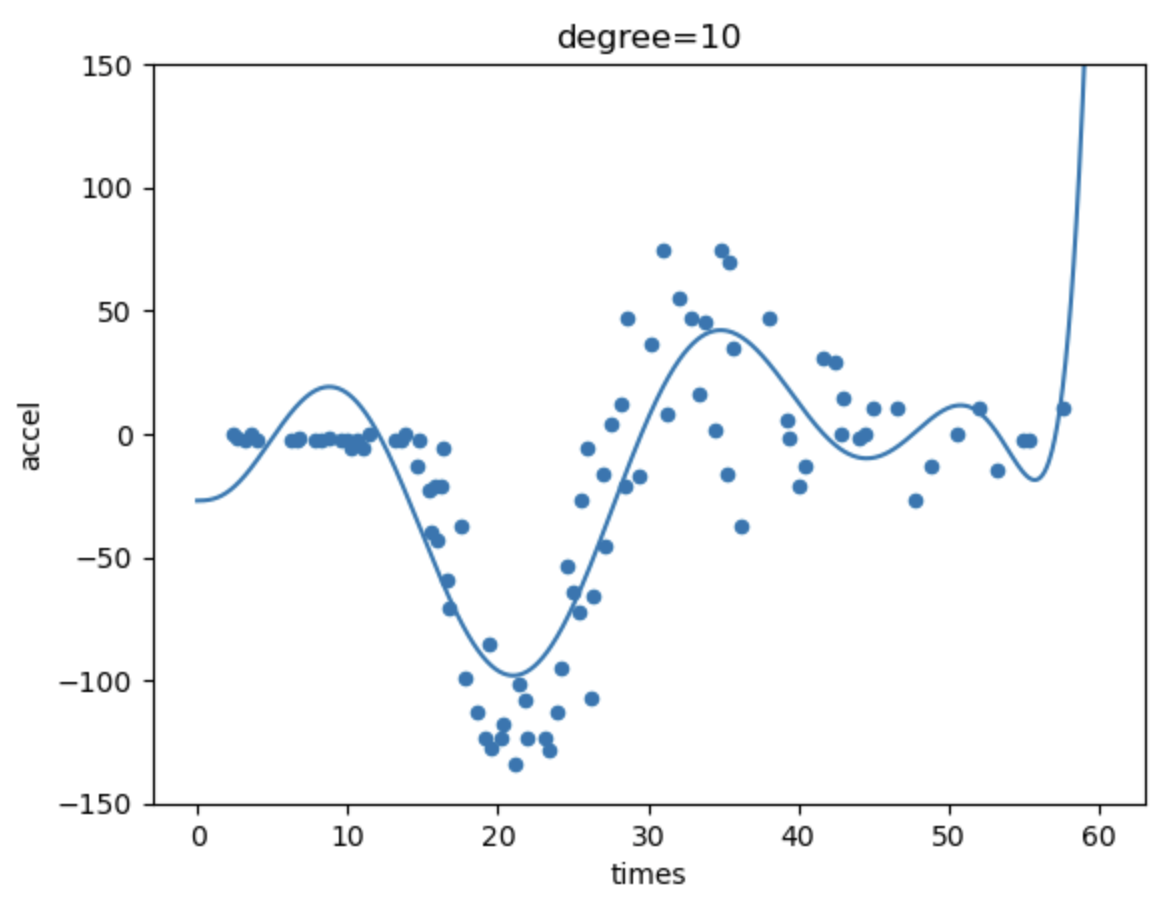
  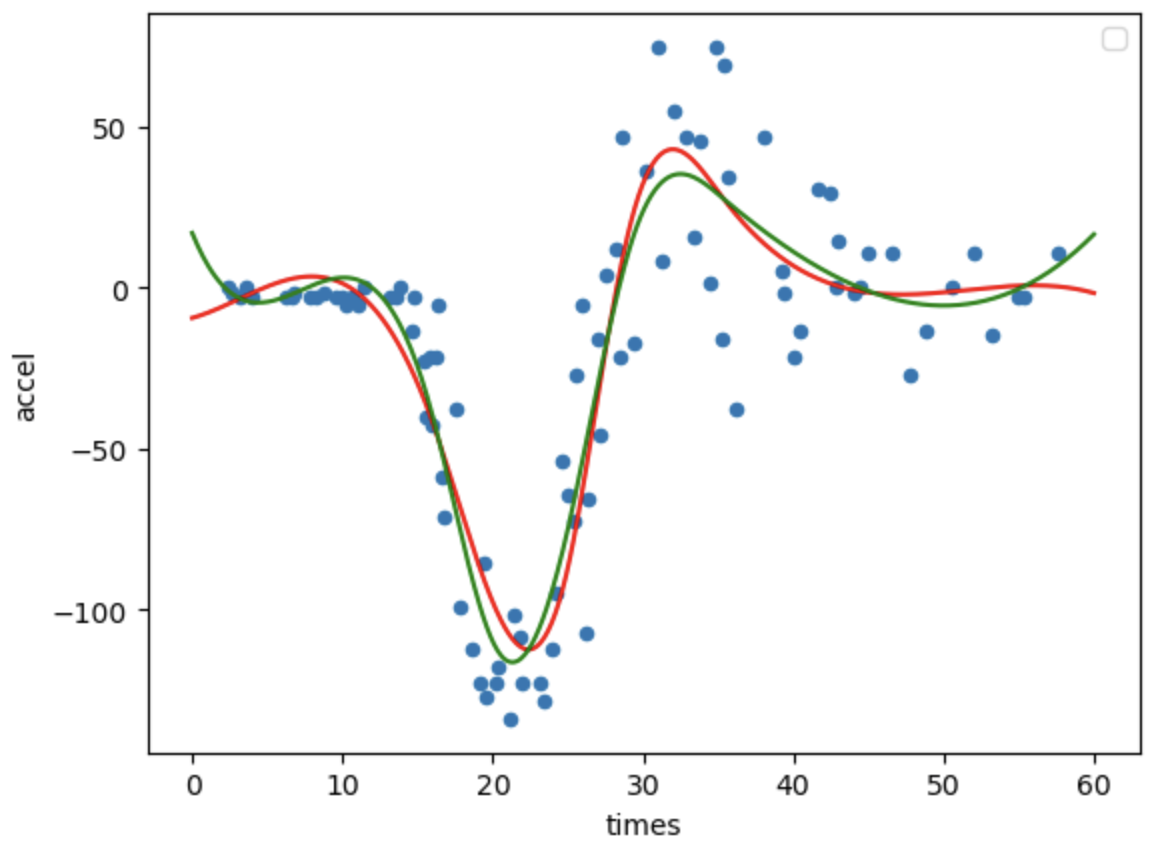
</div>

Figure 1: (Left) Polynomial regression with degree 10 fit on the motorcycle dataset. (Right) Natural cublic splines with two different penalty parameters.

But as we noted earlier in Problem 3, a data scientist should never report or visualize their results without some sense of noise in their estimates. Let $f(X)$ denote your polynomial regression or spline model and assume that

$Y = f(X) + ε$, (6)

where $ε ∼ N (0, σ 2 )$, for some parameter $σ^2 > 0$ to be estimated from the data, and use the results from Lecture 1 to plot confidence intervals around the function $f(X)$.

Let $f(X)$ denote your polynomial regression or spline model and assume that $Y = f(X) + ε$, where $ε ∼ N (0, σ 2 )$, for some parameter $σ^2 > 0$ to be estimated from the data, and use the results from Lecture 1. 
Here is the plot outcome of confidence intervals around the function $f(X)$.

This is the t-distribution's inverse cumulative distribution providing the critical value for a 95% confidence interval. Since a 95% CI captures the central 95% of the distribution, each tail contains 2.5%, and the cumulative probability up to the end of the right tail is 0.975. The second argument (df) specifies the degrees of freedom, which typically equals the number of observations minus the number of parameters estimated by the model.

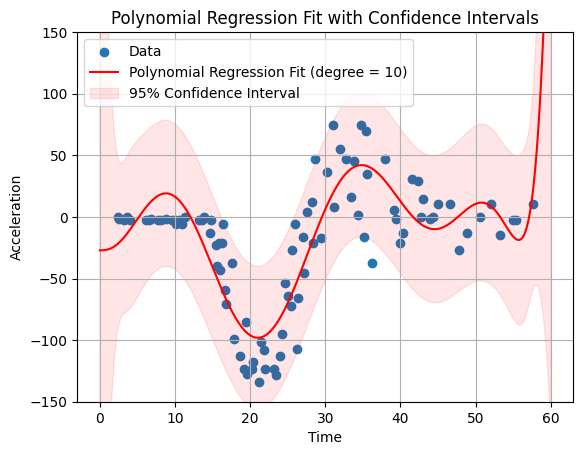

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")


df = pd.read_csv('motorcycle.csv')
df = df[~ df['times'].duplicated()]

degree = 10

lr = LinearRegression()
pr = PolynomialFeatures(degree=degree)

X = df['times'].to_frame()
Y = df['accel']

X_poly = pr.fit_transform(X)
lr.fit(X_poly, Y)

x_line = np.linspace(0, 60, 1000)
x_line_poly = pr.transform(x_line.reshape(-1, 1))
y_line = lr.predict(x_line_poly)

y_pred = lr.predict(X_poly)

residuals = Y - y_pred
n = len(Y)
p = X_poly.shape[1]
df_resid = n - p
sigma_hat_squared = np.sum(residuals**2) / df_resid

CI_upper = []
CI_lower = []
for i in range(len(x_line)):
    x_new_poly = x_line_poly[i:i+1]
    CI_error = t.ppf(0.975, df_resid) * np.sqrt(sigma_hat_squared * (1 + np.dot(np.dot(x_new_poly, np.linalg.inv(np.dot(X_poly.T, X_poly))), x_new_poly.T)))
    CI_upper.append(y_line[i] + CI_error)
    CI_lower.append(y_line[i] - CI_error)

plt.scatter(X, Y, label='Data')
plt.plot(x_line, y_line, color='red', label=f'Polynomial Regression Fit (degree = {degree})')
plt.fill_between(x_line.ravel(), np.ravel(CI_lower), np.ravel(CI_upper), color='red', alpha=0.1, label='95% Confidence Interval')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.ylim(-150, 150)
plt.title('Polynomial Regression Fit with Confidence Intervals')
plt.legend()
plt.grid(True)
plt.show()

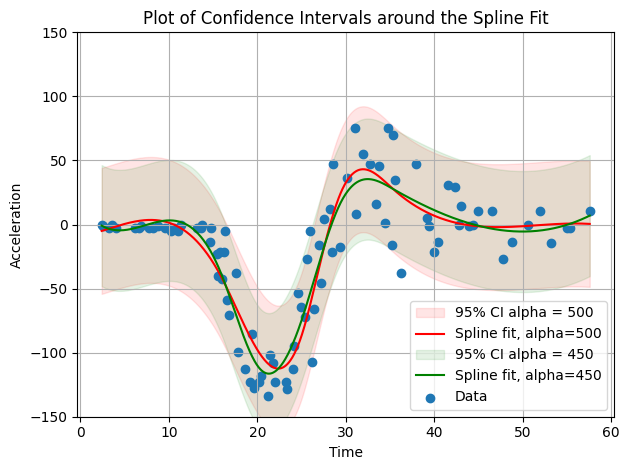

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t
from scipy.interpolate import UnivariateSpline

alphas_colors = [(500, 'red'), (450, 'green')]

df = pd.read_csv('motorcycle.csv')
df = df[~df['times'].duplicated()]
X = df['times'].values
Y = df['accel'].values

for alpha, color in alphas_colors:
    spl = UnivariateSpline(X, Y, s = alpha * len(X))
    x_line = np.linspace(X.min(), X.max(), 1000)
    y_line = spl(x_line)
    y_pred = spl(X)
    
    residuals = Y - y_pred
    df = len(Y) - (spl.get_knots().size + spl.get_coeffs().size)
    sigma_hat_squared = np.sum(residuals ** 2) / df
    
    CI_upper = []
    CI_lower = []
    for x in x_line:
        f_hat_x = spl(x)
        CI_error = t.ppf(0.975, df) * np.sqrt(sigma_hat_squared * (1 + 1 / len(X))) 
        CI_upper.append(f_hat_x + CI_error)
        CI_lower.append(f_hat_x - CI_error)
    
    plt.fill_between(x_line, CI_lower, CI_upper, color = color, alpha = 0.1, label=f'95% CI alpha = {alpha}')
    plt.plot(x_line, y_line, color=color, label = f"Spline fit, alpha={alpha}")
    
plt.title('Plot of Confidence Intervals around the Spline Fit')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.ylim(-150, 150)
plt.scatter(X, Y, label = 'Data')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

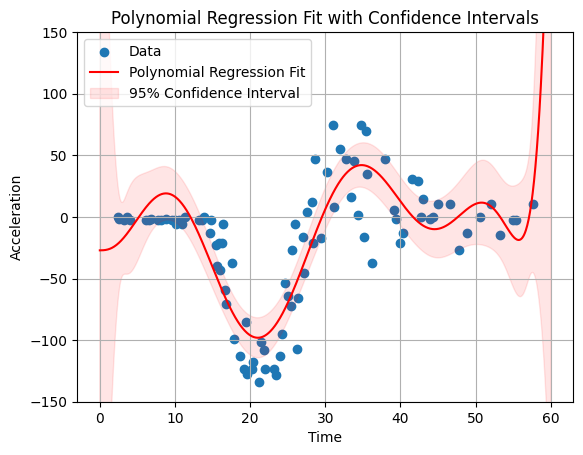

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")


df = pd.read_csv('motorcycle.csv')
df = df[~ df['times'].duplicated()]

degree = 10

lr = LinearRegression()
pr = PolynomialFeatures(degree=degree)

X = df['times'].to_frame()
Y = df['accel']

X_poly = pr.fit_transform(X)
lr.fit(X_poly, Y)

x_line = np.linspace(0, 60, 1000)
x_line_poly = pr.transform(x_line.reshape(-1, 1))
y_line = lr.predict(x_line_poly)
y_pred = lr.predict(X_poly)

residuals = Y - y_pred

n = len(Y)
p = X_poly.shape[1]
sigma_squared = residuals @ residuals.T / (n - p - 1)

var_covar_matrix = np.linalg.inv(X_poly.T @ X_poly) * sigma_squared

se = np.sqrt([x_line_poly[i].T @ var_covar_matrix @ x_line_poly[i] for i in range(len(x_line_poly))])

alpha = 0.025
dof = n - p - 1
t_critical = t.ppf(1 - alpha / 2, dof)
CI_lower = y_line - t_critical * se
CI_upper = y_line + t_critical * se

plt.scatter(X, Y, label='Data')
plt.plot(x_line, y_line, color='red', label='Polynomial Regression Fit')
plt.fill_between(x_line, CI_lower, CI_upper, color='red', alpha=0.1, label='95% Confidence Interval')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.ylim(-150, 150)
plt.title('Polynomial Regression Fit with Confidence Intervals')
plt.legend()
plt.grid(True)
plt.show()

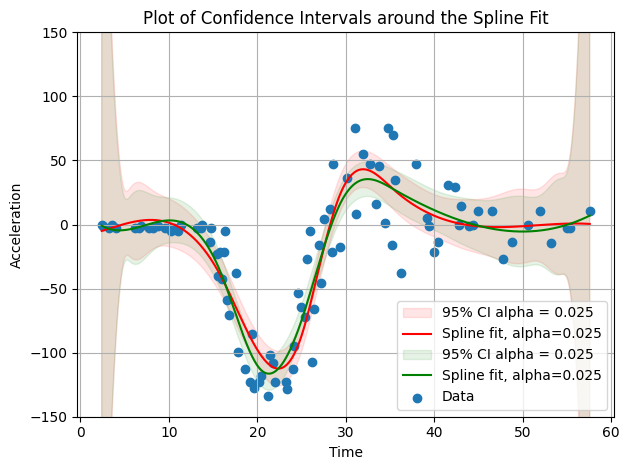

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t
from scipy.interpolate import UnivariateSpline

alphas_colors = [(500, 'red'), (450, 'green')]

df = pd.read_csv('motorcycle.csv')
df = df[~df['times'].duplicated()]
X = df['times'].values
Y = df['accel'].values

for alpha, color in alphas_colors:
    spl = UnivariateSpline(X, Y, s = alpha * len(X))
    x_line = np.linspace(X.min(), X.max(), 1000)
    y_line = spl(x_line)
    y_pred = spl(X)
    
    residuals = Y - y_pred
    n = len(Y)
    p = X_poly.shape[1]
    sigma_squared = np.sum(residuals**2) / (n - p - 1)
    
    var_covar_matrix = np.linalg.inv(X_poly.T @ X_poly) * sigma_squared

    prediction_se = np.sqrt(np.diagonal(x_line_poly @ var_covar_matrix @ x_line_poly.T))
    alpha = 0.025
    dof = n - p - 1
    t_critical = t.ppf(1 - alpha / 2, dof)

    CI_lower = y_line - t_critical * prediction_se
    CI_upper = y_line + t_critical * prediction_se
    
    plt.fill_between(x_line, CI_lower, CI_upper, color = color, alpha = 0.1, label=f'95% CI alpha = {alpha}')
    plt.plot(x_line, y_line, color=color, label = f"Spline fit, alpha={alpha}")

plt.title('Plot of Confidence Intervals around the Spline Fit')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.ylim(-150, 150)
plt.scatter(X, Y, label = 'Data')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()